# SALE PRICE FORECASTING - WORK IN PROGRESS....

<a id="A"></a>
# <div style="text-align:left; border-radius:10px 50px; padding:15px; color:white; margin:0; font-size:95%; font-family:Pacifico; background-color:indigo; overflow:hidden"><b> • Import Dependencies </b></div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm, skew 
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
fig_size = [12, 6]

<a id="A"></a>
# <div style="text-align:left; border-radius:10px 50px; padding:15px; color:white; margin:0; font-size:95%; font-family:Pacifico; background-color:indigo; overflow:hidden"><b> • Assemble Datasets </b></div>


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black">  • Load All Datasets </span> 

In [2]:
path_oil = '../dataset/oil.csv'
path_holidays = '../dataset/holidays_events.csv'
path_stores = '../dataset/stores.csv'
path_train = '../dataset/train.csv'
path_transactions = '../dataset/transactions.csv'
path_test = '../dataset/test.csv'

df_oil = pd.read_csv(path_oil, parse_dates=['date'], index_col='date')
df_holidays = pd.read_csv(path_holidays, parse_dates=['date'], index_col='date')
df_stores = pd.read_csv(path_stores)
df_train = pd.read_csv(path_train, parse_dates=['date'], index_col='date')
df_transactions = pd.read_csv(path_transactions, parse_dates=['date'], index_col='date')
df_test = pd.read_csv(path_test, parse_dates=['date'], index_col='date')


In [3]:
df_train.tail()

id  store_nbr                      family     sales  \
date                                                                   
2017-08-15  3000883          9                     POULTRY   438.133   
2017-08-15  3000884          9              PREPARED FOODS   154.553   
2017-08-15  3000885          9                     PRODUCE  2419.729   
2017-08-15  3000886          9  SCHOOL AND OFFICE SUPPLIES   121.000   
2017-08-15  3000887          9                     SEAFOOD    16.000   

            onpromotion  
date                     
2017-08-15            0  
2017-08-15            1  
2017-08-15          148  
2017-08-15            8  
2017-08-15            0

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black">  • Dataset Merging </span> 

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black">  
• Merging Training and Transactions:
</span> 

In [4]:
# Aggregate 'sales' and 'onpromotion' by grouping both datasets as 'date'.
df_1  = pd.DataFrame(df_train.groupby('date')[['sales', 'onpromotion']].sum())
df_2 = pd.DataFrame(df_transactions.groupby('date')[['transactions']].sum())

print(f'Train Dataset: {df_1.shape}')
print(f'Transactions Dataset: {df_2.shape}')

# Now merge the data based on 'date' to avoid potential conflicts.
df_merge = pd.merge(df_1, df_2, on='date', how='left')
print(f'Merged Dataset: {df_merge.shape}')
df_merge.head()

Train Dataset: (1684, 2)
Transactions Dataset: (1682, 1)
Merged Dataset: (1684, 3)


sales  onpromotion  transactions
date                                                
2013-01-01    2511.618999            0         770.0
2013-01-02  496092.417944            0       93215.0
2013-01-03  361461.231124            0       78504.0
2013-01-04  354459.677093            0       78494.0
2013-01-05  477350.121229            0       93573.0

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black">  
• Merging with Holidays:
</span> 

In [5]:
# Merge Holidays based on 'date'.
df_merge = pd.merge(df_merge, df_holidays, on='date', how='left')
print(f'Holiday Dataset: {df_holidays.shape}')
print(f'Merged Dataset: {df_merge.shape}')
df_merge.head()

Holiday Dataset: (350, 5)
Merged Dataset: (1714, 8)


sales  onpromotion  transactions      type    locale  \
date                                                                       
2013-01-01    2511.618999            0         770.0   Holiday  National   
2013-01-02  496092.417944            0       93215.0       NaN       NaN   
2013-01-03  361461.231124            0       78504.0       NaN       NaN   
2013-01-04  354459.677093            0       78494.0       NaN       NaN   
2013-01-05  477350.121229            0       93573.0  Work Day  National   

           locale_name              description transferred  
date                                                         
2013-01-01     Ecuador       Primer dia del ano       False  
2013-01-02         NaN                      NaN         NaN  
2013-01-03         NaN                      NaN         NaN  
2013-01-04         NaN                      NaN         NaN  
2013-01-05     Ecuador  Recupero puente Navidad       False

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black">  
• Merging with Oil Prices:
</span> 

In [6]:
# Merge Oil Prices based on 'date'.
df_merge = pd.merge(df_merge, df_oil, on='date', how='left')

print(f'Oil Dataset: {df_oil.shape}')
print(f'Merged Dataset: {df_merge.shape}')

df_merge.head()

Oil Dataset: (1218, 1)
Merged Dataset: (1714, 9)


sales  onpromotion  transactions      type    locale  \
date                                                                       
2013-01-01    2511.618999            0         770.0   Holiday  National   
2013-01-02  496092.417944            0       93215.0       NaN       NaN   
2013-01-03  361461.231124            0       78504.0       NaN       NaN   
2013-01-04  354459.677093            0       78494.0       NaN       NaN   
2013-01-05  477350.121229            0       93573.0  Work Day  National   

           locale_name              description transferred  dcoilwtico  
date                                                                     
2013-01-01     Ecuador       Primer dia del ano       False         NaN  
2013-01-02         NaN                      NaN         NaN       93.14  
2013-01-03         NaN                      NaN         NaN       92.97  
2013-01-04         NaN                      NaN         NaN       93.12  
2013-01-05     Ecuador  Recupero puente Navidad       False         NaN

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black">  • Dataset Dictionary </span> 

In [7]:
dfs = {
    "Training":df_train,
    "Holiday Events": df_holidays,
    "Oil": df_oil,
    "Stores": df_stores,
    "Transactions": df_transactions,
    "Merged": df_merge 
}

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black">  • Explode the date index into separate columns for day, month, and year </span> 

In [8]:
for name, df in dfs.items():
    try:
        df['day'] = df.index.day
        df['month'] = df.index.month
        df['year'] = df.index.year
        
    except Exception as exc:
        print(f'{name} dataset does not conatin date index. {exc}')

    finally:
        print(f'Columns successfully added for {name}')


Columns successfully added for Training
Columns successfully added for Holiday Events
Columns successfully added for Oil
Stores dataset does not conatin date index. 'RangeIndex' object has no attribute 'day'
Columns successfully added for Stores
Columns successfully added for Transactions
Columns successfully added for Merged


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black">  
• Dataframes Analysis
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black">  
- A collection of dataframes to be utilized for exploration purposes.
</span> 

In [9]:
df_train_store = pd.merge(df_train, df_stores, on='store_nbr', how='inner')  
df_train_oil = pd.merge(df_train, df_oil, on='date', how='inner')  
df_train_holidays = pd.merge(df_train, df_holidays, on='date', how='inner')

<a id="A"></a>
# <div style="text-align:left; border-radius:10px 50px; padding:15px; color:white; margin:0; font-size:95%; font-family:Pacifico; background-color:indigo; overflow:hidden"><b> • Dataframe Analysis </b></div>


<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
This section focuses on baseline dataframe characteristics for all the datasets.
</span> 

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Dataframe Shapes:
</span> 

In [10]:
for name, df in dfs.items():
    print(f'Shape of the {name} dataset {df.shape}')
    

Shape of the Training dataset (3000888, 8)
Shape of the Holiday Events dataset (350, 8)
Shape of the Oil dataset (1218, 4)
Shape of the Stores dataset (54, 5)
Shape of the Transactions dataset (83488, 5)
Shape of the Merged dataset (1714, 12)


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Dataset Informations:
</span> 

In [11]:
for name, df in dfs.items():
    print(f'>> {name}')
    df.info()
    print('-'*25)


>> Training
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
 5   day          int32  
 6   month        int32  
 7   year         int32  
dtypes: float64(1), int32(3), int64(3), object(1)
memory usage: 171.7+ MB
-------------------------
>> Holiday Events
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
 5   day          350 non-null    int32 
 6   month        350 non-null  

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Dataset Descriptions:
</span> 

In [12]:
for name, df in dfs.items():
    print(f'>> {name}:\n{df.describe()}')
    print('-'*25)
    

>> Training:
                 id     store_nbr         sales   onpromotion           day  \
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06   
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00  1.563005e+01   
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01  8.794789e+00   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00  8.000000e+00   
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00  1.600000e+01   
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00  2.300000e+01   
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02  3.100000e+01   

              month          year  
count  3.000888e+06  3.000888e+06  
mean   6.207838e+00  2.014838e+03  
std    3.385668e+00  1.345518e+00  
min    1.000000e+00  2.013000e+03  
25%    3.000000e+00  2.014000e+03  
50%    6.000000e+00  2.015000e+03  
75%    9.000000e+00  2.

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Null Inspections:
</span> 

In [13]:
for name, df in dfs.items():
    print(f"Missing values in {name} dataset:")
    print(df.isnull().sum())
    print('-'*25)
    

Missing values in Training dataset:
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
day            0
month          0
year           0
dtype: int64
-------------------------
Missing values in Holiday Events dataset:
type           0
locale         0
locale_name    0
description    0
transferred    0
day            0
month          0
year           0
dtype: int64
-------------------------
Missing values in Oil dataset:
dcoilwtico    43
day            0
month          0
year           0
dtype: int64
-------------------------
Missing values in Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
-------------------------
Missing values in Transactions dataset:
store_nbr       0
transactions    0
day             0
month           0
year            0
dtype: int64
-------------------------
Missing values in Merged dataset:
sales              0
onpromotion        0
transactions       2
type            1432

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Duplicated Entries:
</span> 

In [14]:
for name, df in dfs.items():
    print(f"Duplicated entries for {name} dataset:")
    print(df.duplicated().sum())
    print('-'*25)


Duplicated entries for Training dataset:
0
-------------------------
Duplicated entries for Holiday Events dataset:
0
-------------------------
Duplicated entries for Oil dataset:
0
-------------------------
Duplicated entries for Stores dataset:
0
-------------------------
Duplicated entries for Transactions dataset:
0
-------------------------
Duplicated entries for Merged dataset:
0
-------------------------


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Skewness:
</span> 

In [15]:
for name, df in dfs.items():
    df_num = df.select_dtypes(include=np.number)
    print(f'>> Skewness for the numerical variable of the {name} dataset:\n{df_num.skew()}\n')
    print('-'*25)


>> Skewness for the numerical variable of the Training dataset:
id            -9.492127e-16
store_nbr      0.000000e+00
sales          7.358758e+00
onpromotion    1.116656e+01
day            2.374403e-02
month          1.128158e-01
year           9.626854e-02
dtype: float64

-------------------------
>> Skewness for the numerical variable of the Holiday Events dataset:
day      0.06333
month   -0.09426
year    -0.19479
dtype: float64

-------------------------
>> Skewness for the numerical variable of the Oil dataset:
dcoilwtico    0.321648
day           0.007013
month         0.097233
year          0.087949
dtype: float64

-------------------------
>> Skewness for the numerical variable of the Stores dataset:
store_nbr    0.000000
cluster      0.041241
dtype: float64

-------------------------
>> Skewness for the numerical variable of the Transactions dataset:
store_nbr       0.003456
transactions    1.518351
day             0.021466
month           0.107987
year            0.027812
d

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Kurtosis:
</span>

In [16]:
for name, df in dfs.items():
    df_num = df.select_dtypes(include=np.number)
    print(f'>> Kurtosis for the numerical variable of the {name} dataset:\n{df_num.kurt()}\n')
    print('-'*25)


>> Kurtosis for the numerical variable of the Training dataset:
id              -1.200000
store_nbr       -1.200823
sales          154.562092
onpromotion    240.871122
day             -1.190669
month           -1.141133
year            -1.195638
dtype: float64

-------------------------
>> Kurtosis for the numerical variable of the Holiday Events dataset:
day     -1.426629
month   -1.268932
year    -1.151970
dtype: float64

-------------------------
>> Kurtosis for the numerical variable of the Oil dataset:
dcoilwtico   -1.612437
day          -1.194407
month        -1.136915
year         -1.208924
dtype: float64

-------------------------
>> Kurtosis for the numerical variable of the Stores dataset:
store_nbr   -1.200000
cluster     -1.260918
dtype: float64

-------------------------
>> Kurtosis for the numerical variable of the Transactions dataset:
store_nbr      -1.235213
transactions    2.567213
day            -1.188409
month          -1.136218
year           -1.199858
dtype: float

<a id="A"></a>
# <div style="text-align:left; border-radius:10px 50px; padding:15px; color:white; margin:0; font-size:95%; font-family:Pacifico; background-color:indigo; overflow:hidden"><b> • Exploratory Data Analysis </b></div>


<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
This section focuses on exploring features by utilizing visualizations.
</span>

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Sales & Promotion Distribution:
</span> 

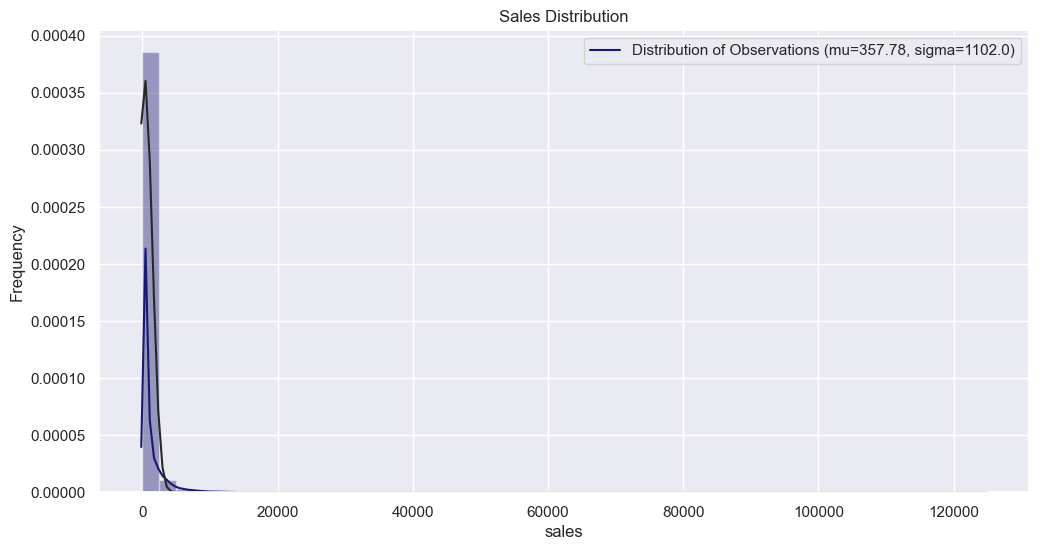

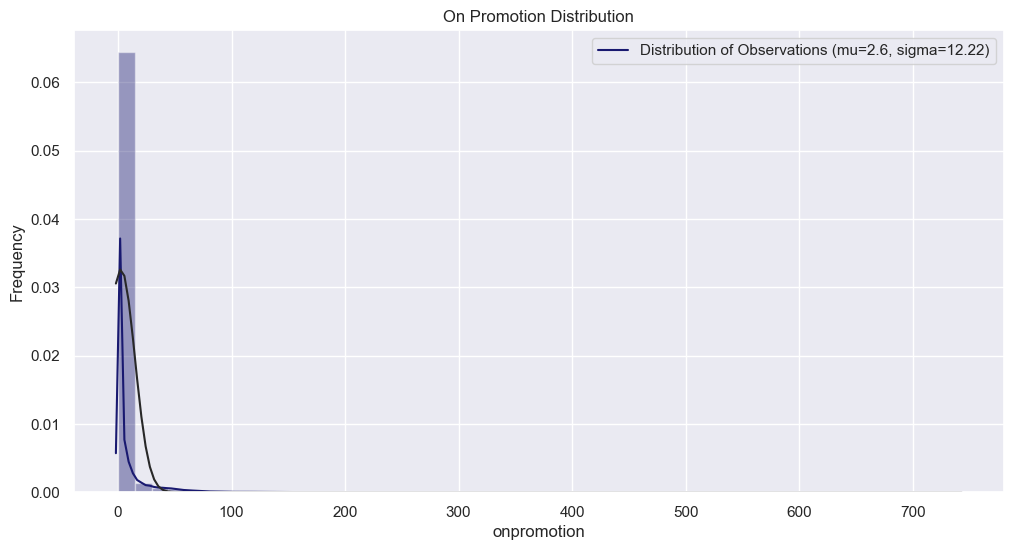

In [17]:
def distplot_feature(target, col):
    sns.set(rc={'figure.figsize':fig_size})        
    sns.distplot(target, fit=norm, color='midnightblue')  
    mu, sigma = norm.fit(target)
    
    plt.legend([f'Distribution of Observations (mu={round(mu,2)}, sigma={round(sigma, 2)})'], loc='upper right')
    plt.ylabel('Frequency')      
    plt.title(f'{col} Distribution', fontsize=12)
    plt.show()

distplot_feature(df_train.sales, 'Sales')
distplot_feature(df_train.onpromotion, 'On Promotion')

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Sale Distribution over the course of Time:
</span> 

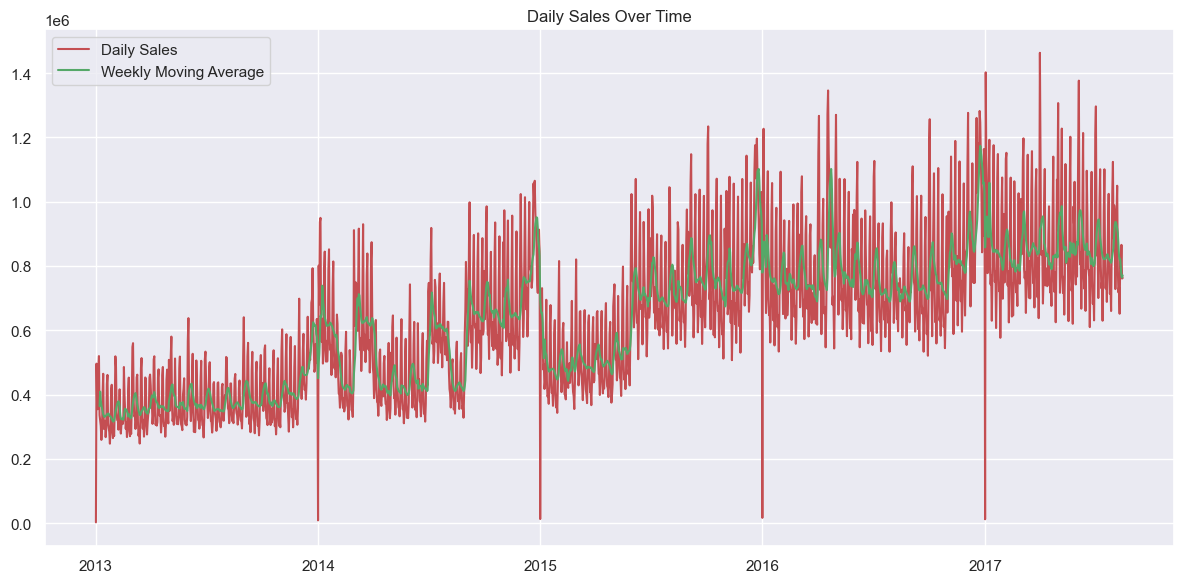

In [18]:
def sales_time(df1, df2):
    plt.figure(figsize=(fig_size))
    plt.plot(df1.index, df1.values, label='Daily Sales', color='r')
    plt.plot(df2.index, df2.values, label='Weekly Moving Average', color='g')
    
    plt.title('Daily Sales Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

daily_sales = df_train.groupby('date')['sales'].sum()
moving_avg = daily_sales.rolling(window=7).mean()

sales_time(daily_sales, moving_avg)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Yearly Graph of Daily Sales:
</span> 

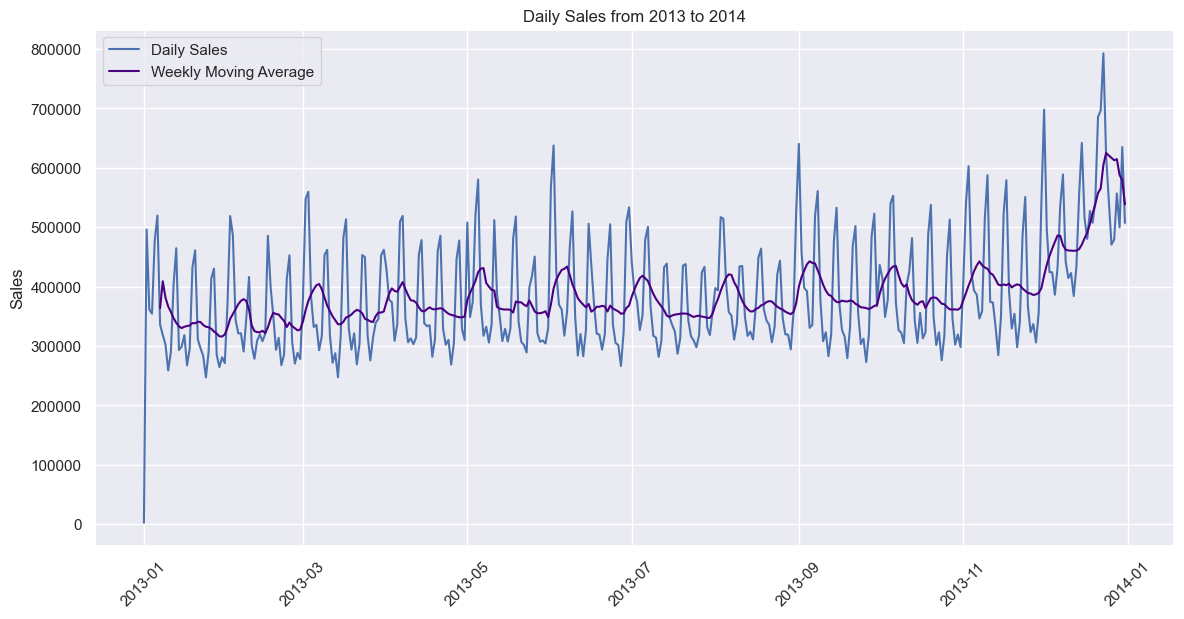

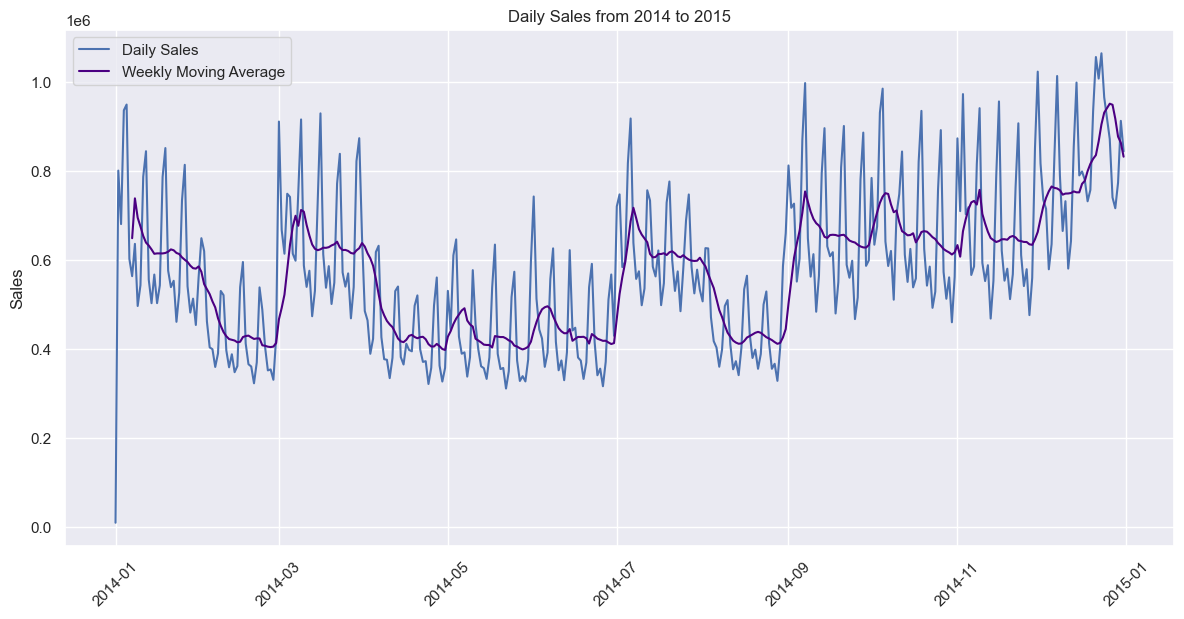

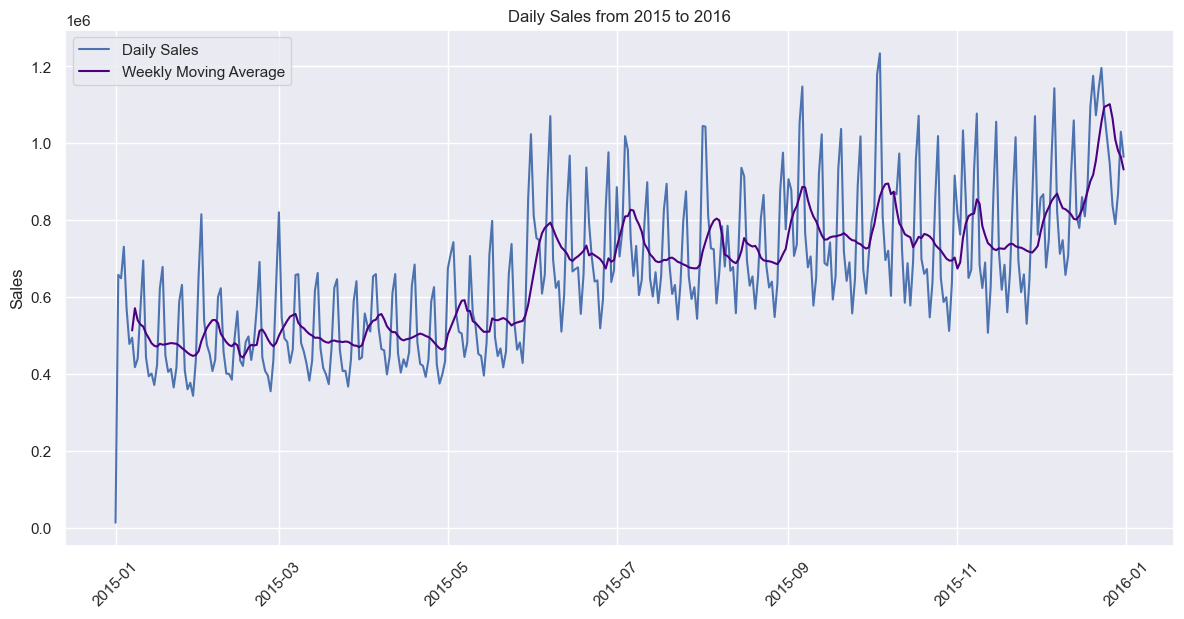

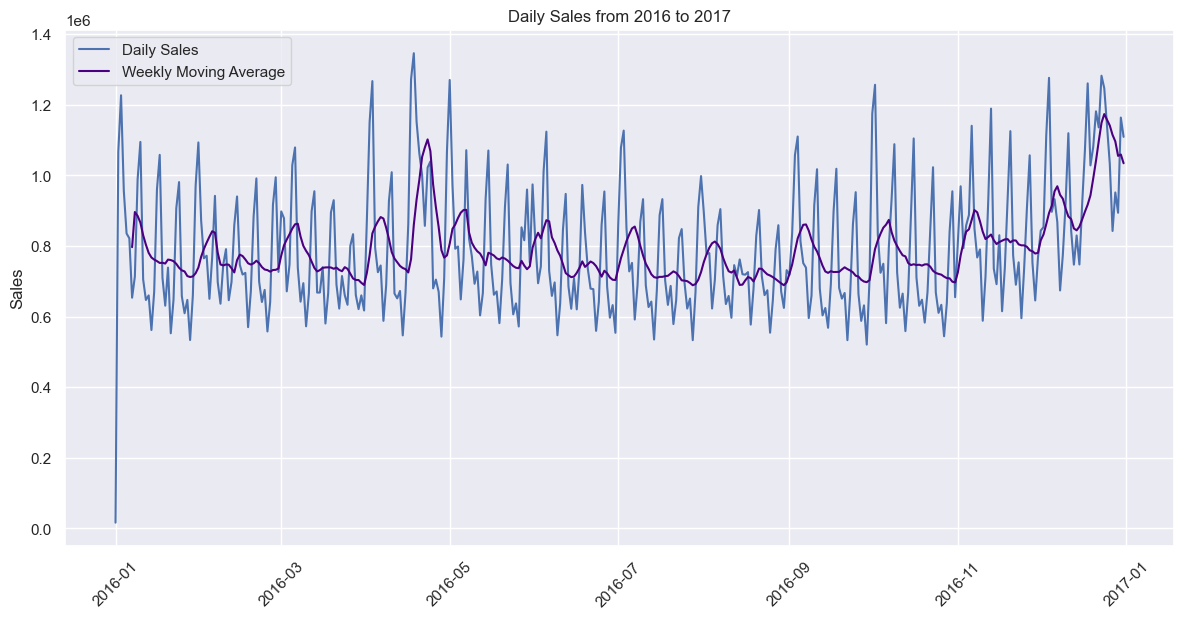

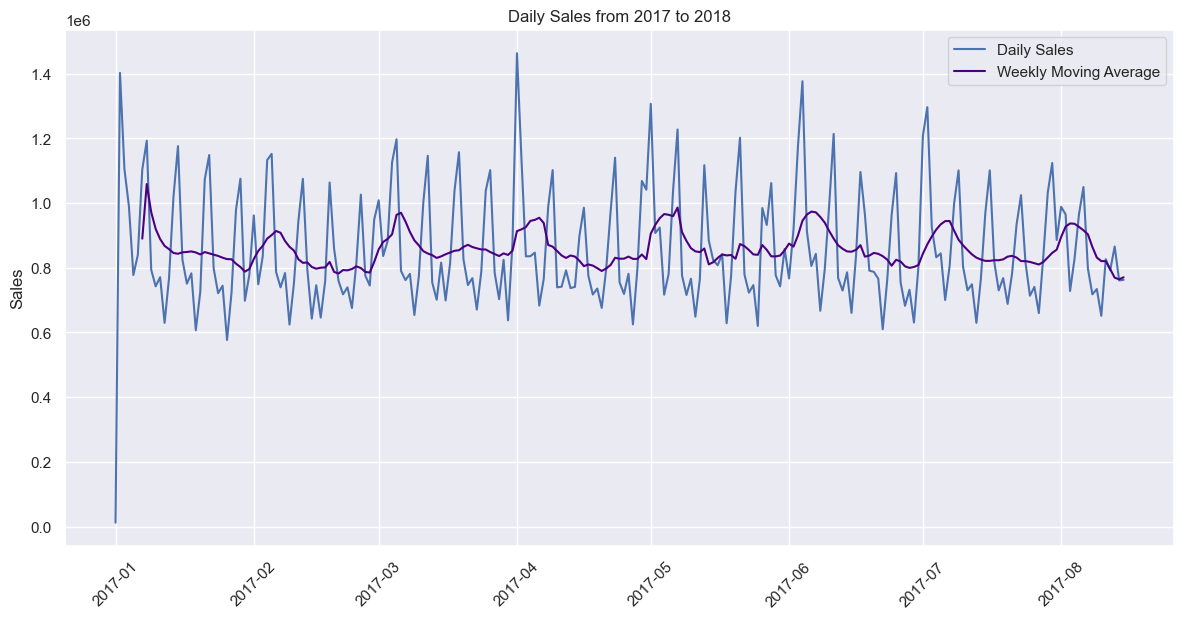

In [19]:
def filter_yearly_graph(df1, df2, year_start, year_end):
    plt.figure(figsize=(fig_size))
    plt.plot(df1.index, df1.values, label='Daily Sales', color='b')
    plt.plot(df2.index, df2.values, label='Weekly Moving Average', color='indigo')
    
    plt.title(f'Daily Sales from {year_start} to {year_end}')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

timeframe = df_train.year.unique()

for year in timeframe:
    mask = (daily_sales.index.year >= year) & (daily_sales.index.year < year+1)
    filtered_daily_sales = daily_sales[mask] 
    moving_avg = filtered_daily_sales.rolling(window=7).mean()   
    
    filter_yearly_graph(filtered_daily_sales, moving_avg, year, year+1)


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Yearly Growth of Product Families:
</span> 

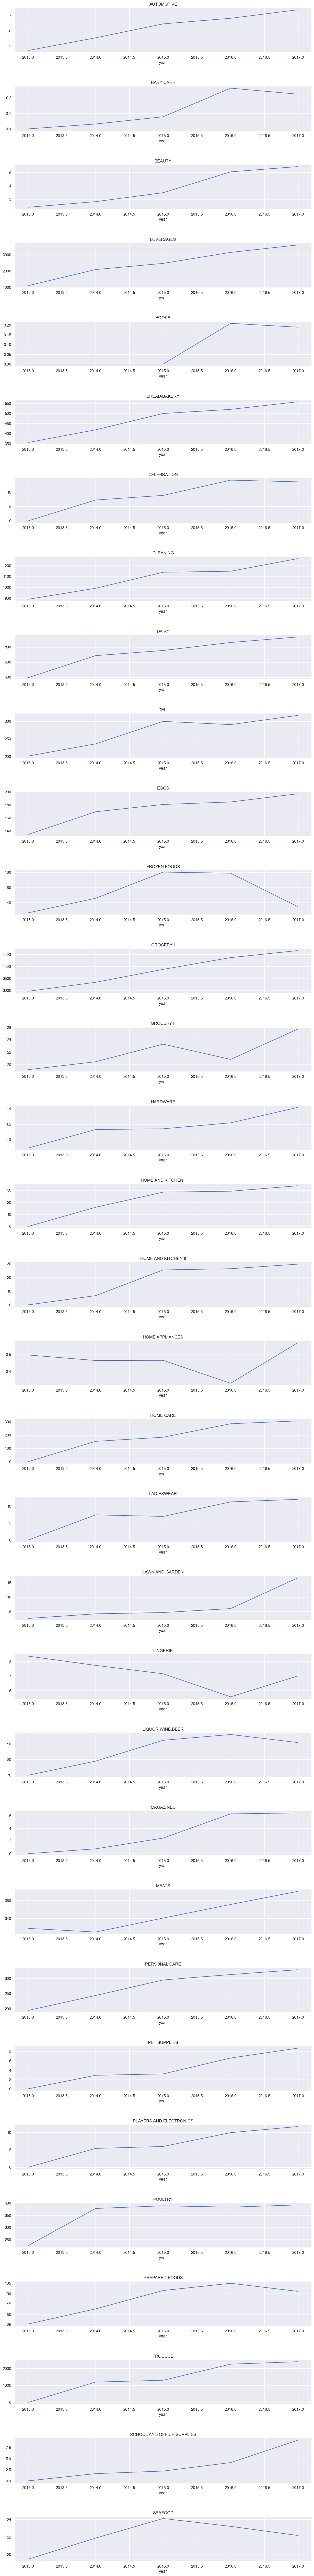

In [20]:
def family_growth(df, family):
    fig= plt.figure(figsize=(15, 130))
    fig.subplots_adjust(hspace=0.75)
    
    for i, product in enumerate(family):
        ax = fig.add_subplot(33, 1, i+1)
        df.query('family==@product').groupby(['year']).sales.mean().plot()
        plt.title(product)

family = df_train.family.unique()
family_growth(df_train, family)
    

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Store Growth on a Monthly basis:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- Store #44 experienced a major boom in July. Additionally, secondary growth includes in January, March, and December
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- Store #3 also experienced a minor growth in July.
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- Store #52 suffered lack of sales but saw a slight improvement in May, June, and July on aggregate.
</span> <br>

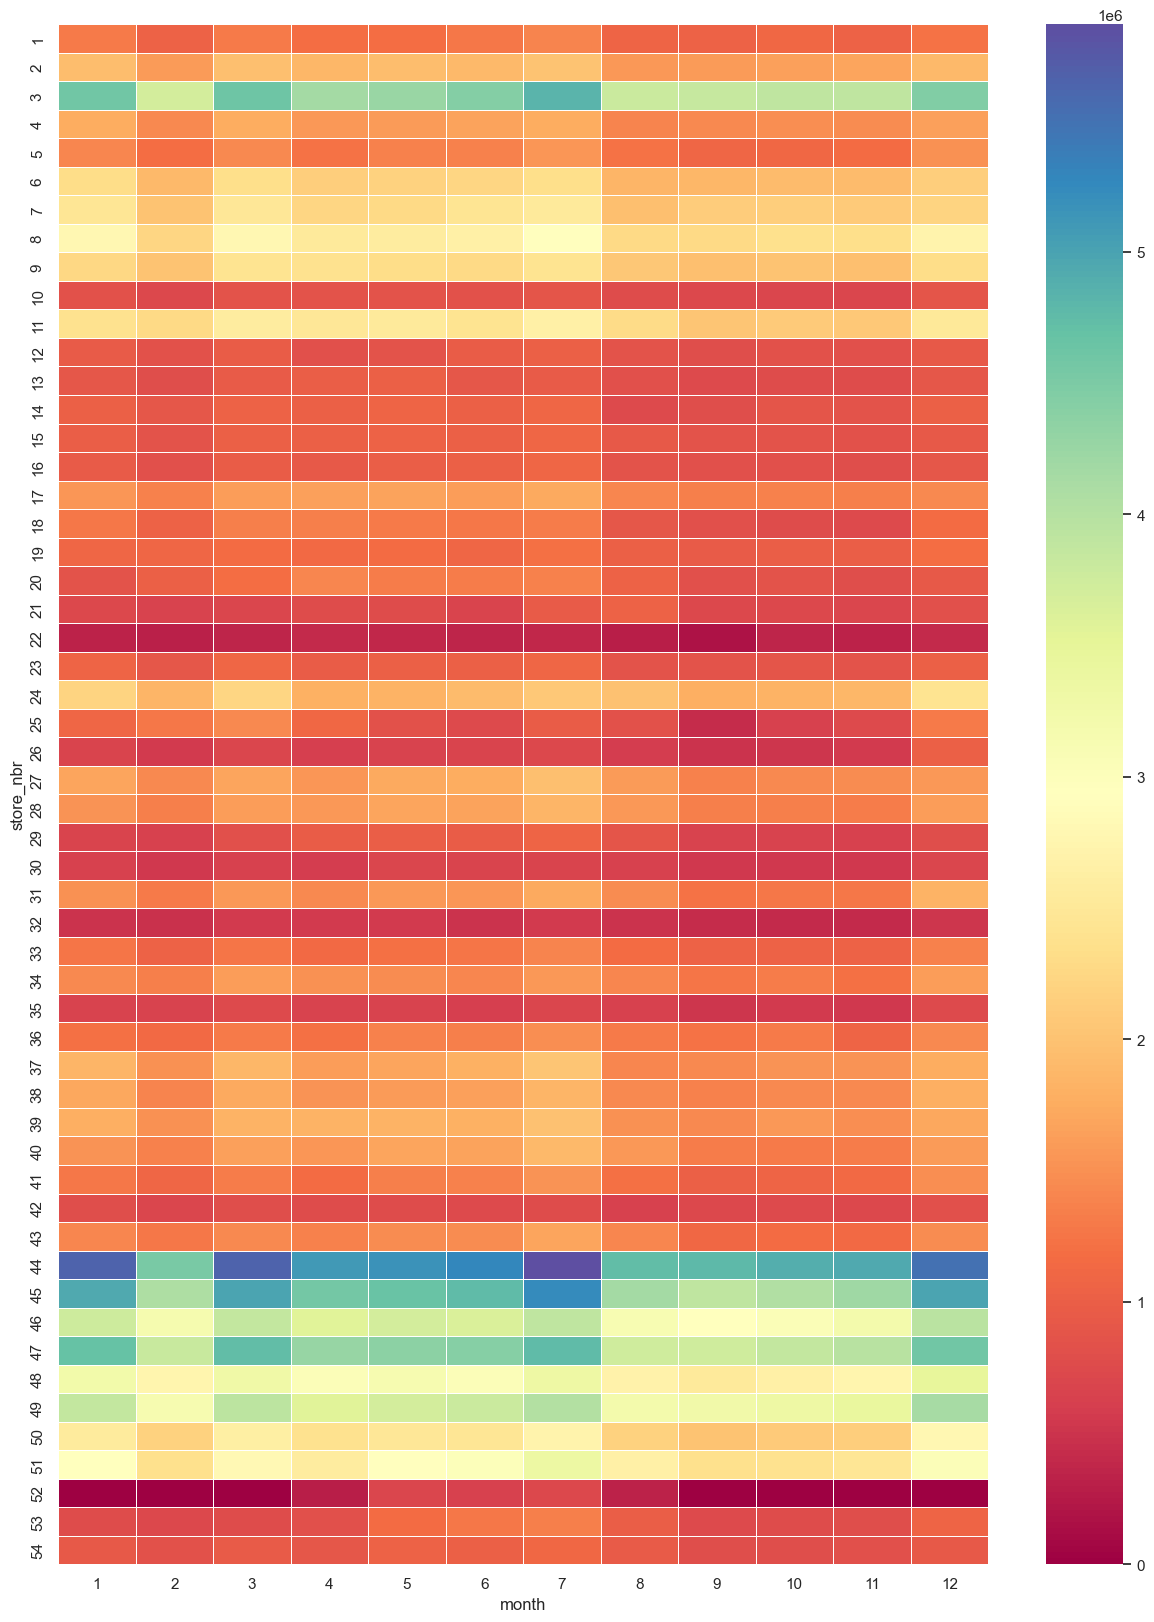

In [21]:
def store_growth(df):
    table = pd.pivot_table(df, values ='sales', index =['store_nbr'], columns =['month'], aggfunc = np.sum)
    fig, ax = plt.subplots(figsize=(15,20))         
    sns.heatmap(table, annot=False, linewidths=.5, ax=ax, cmap="Spectral")
    plt.show()

store_growth(df_train)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Average Daily Sales per Month:
</span> 

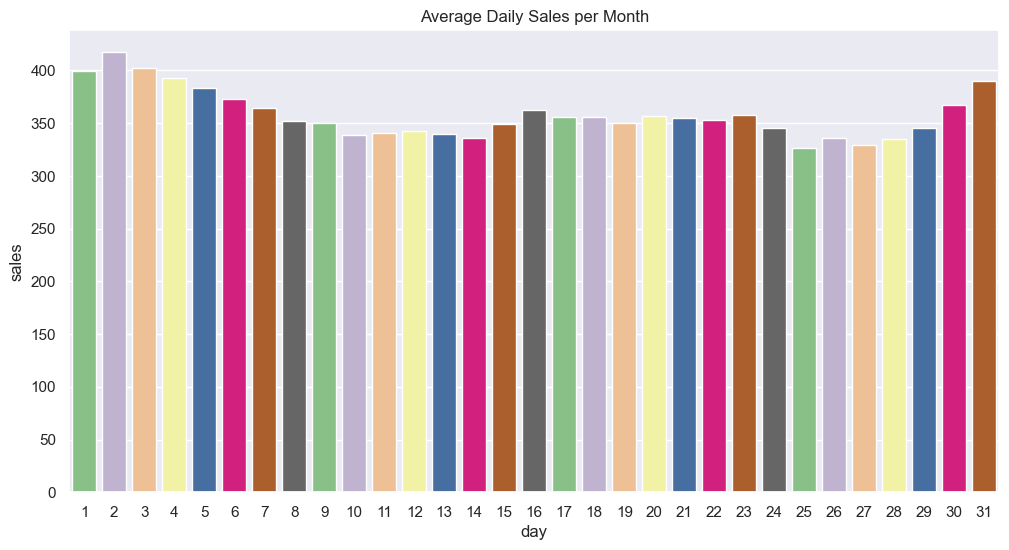

In [22]:
def avg_sales_month(df):
    sns.set(rc={'figure.figsize':fig_size}) 
    sns.barplot(df, palette="Accent")
    plt.title('Average Daily Sales per Month')
    plt.show()

avg_sales_month(df_train.groupby('day').sales.mean())

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Top 10 Stores by Sales and Promotions:
</span> 

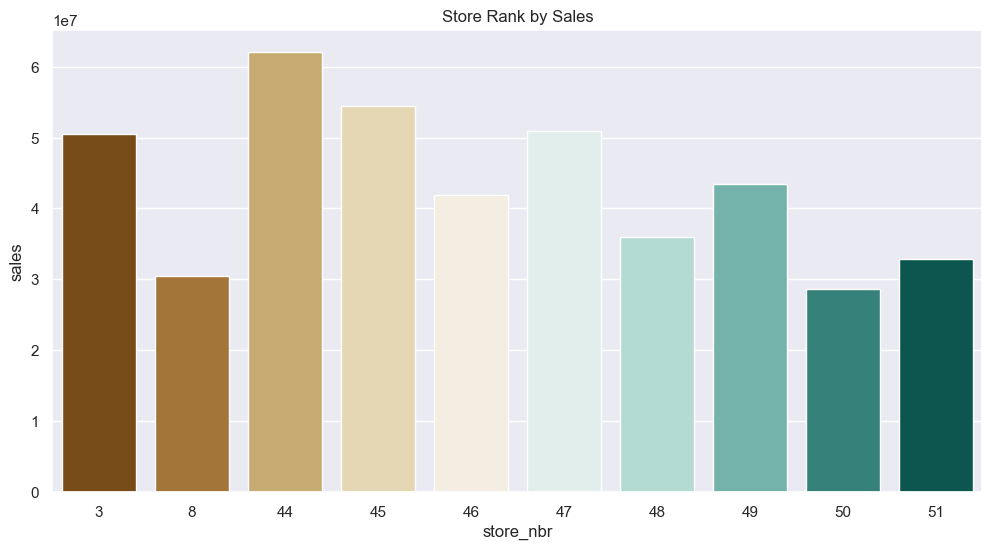

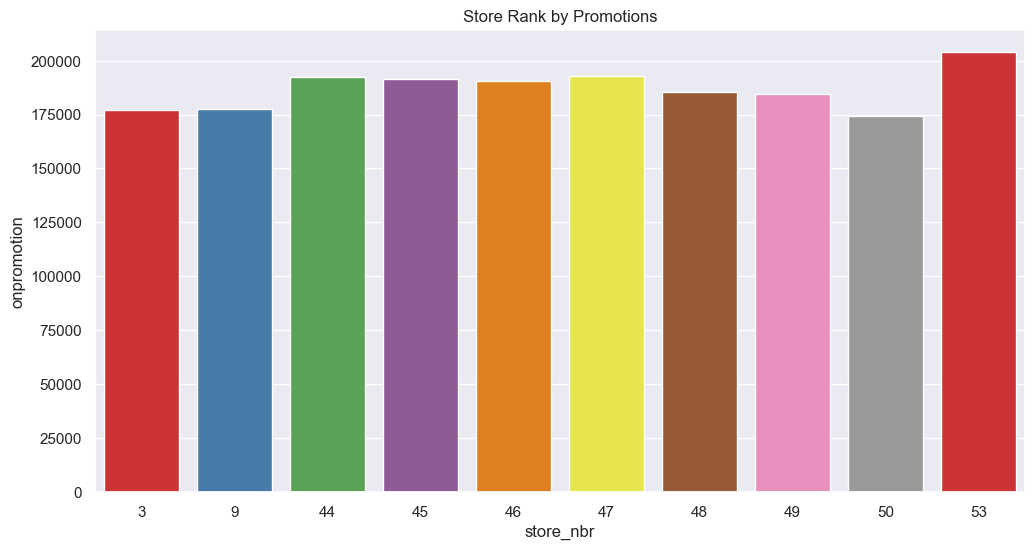

In [23]:
def store_rank(df, title, palette):
    sns.set(rc={'figure.figsize':fig_size}) 
    sns.barplot(df, palette=palette)
    plt.title(title)
    plt.show()

top_stores = df_train.groupby('store_nbr').sales.sum().sort_values(ascending=False).iloc[0:10]
top_promotion = df_train.groupby('store_nbr').onpromotion.sum().sort_values(ascending=False).iloc[0:10]

store_rank(top_stores, 'Store Rank by Sales', "BrBG")
store_rank(top_promotion, 'Store Rank by Promotions', "Set1")


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Promotions on a Monthly and Yearly Basis:
</span> 

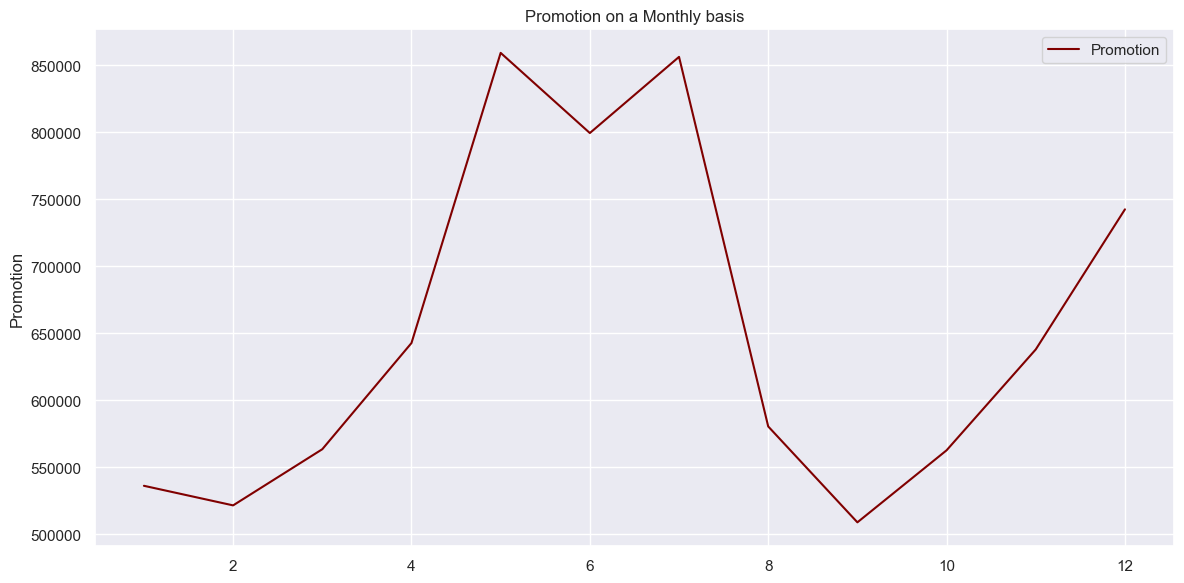

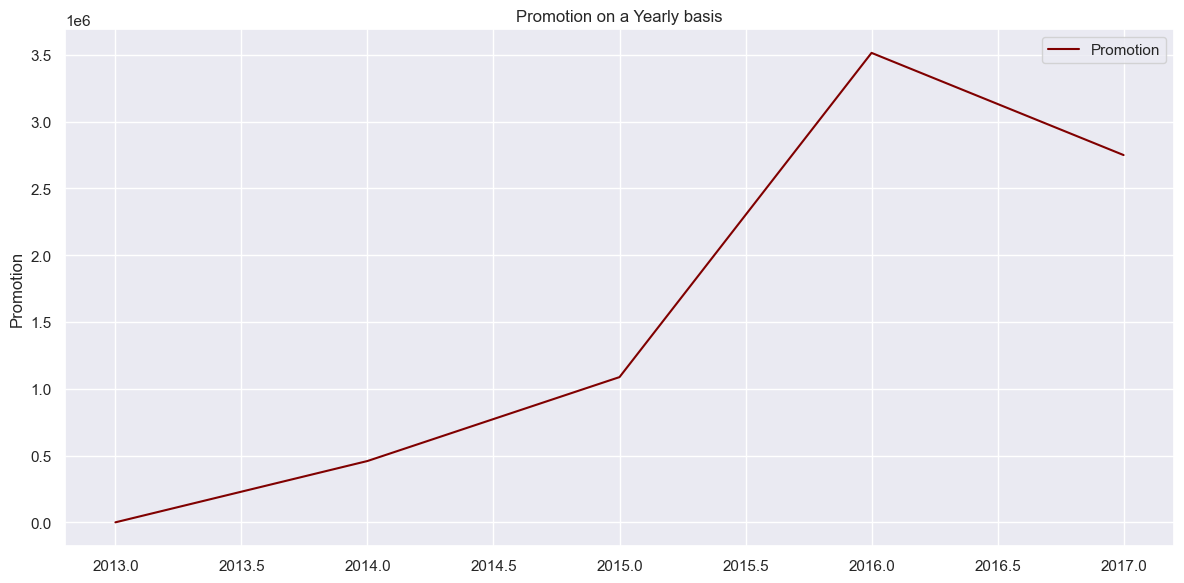

In [24]:
def promo_freq(df, freq):
    plt.figure(figsize=(fig_size))
    plt.plot(df.index, df.values, label='Promotion', color='maroon')
    
    plt.title(f'Promotion on a {freq} basis')
    plt.ylabel('Promotion')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

promo_month = df_train.groupby('month').onpromotion.sum()
promo_year = df_train.groupby('year').onpromotion.sum()

promo_freq(promo_month, 'Monthly')
promo_freq(promo_year, 'Yearly')

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Family and Sales:
</span> 

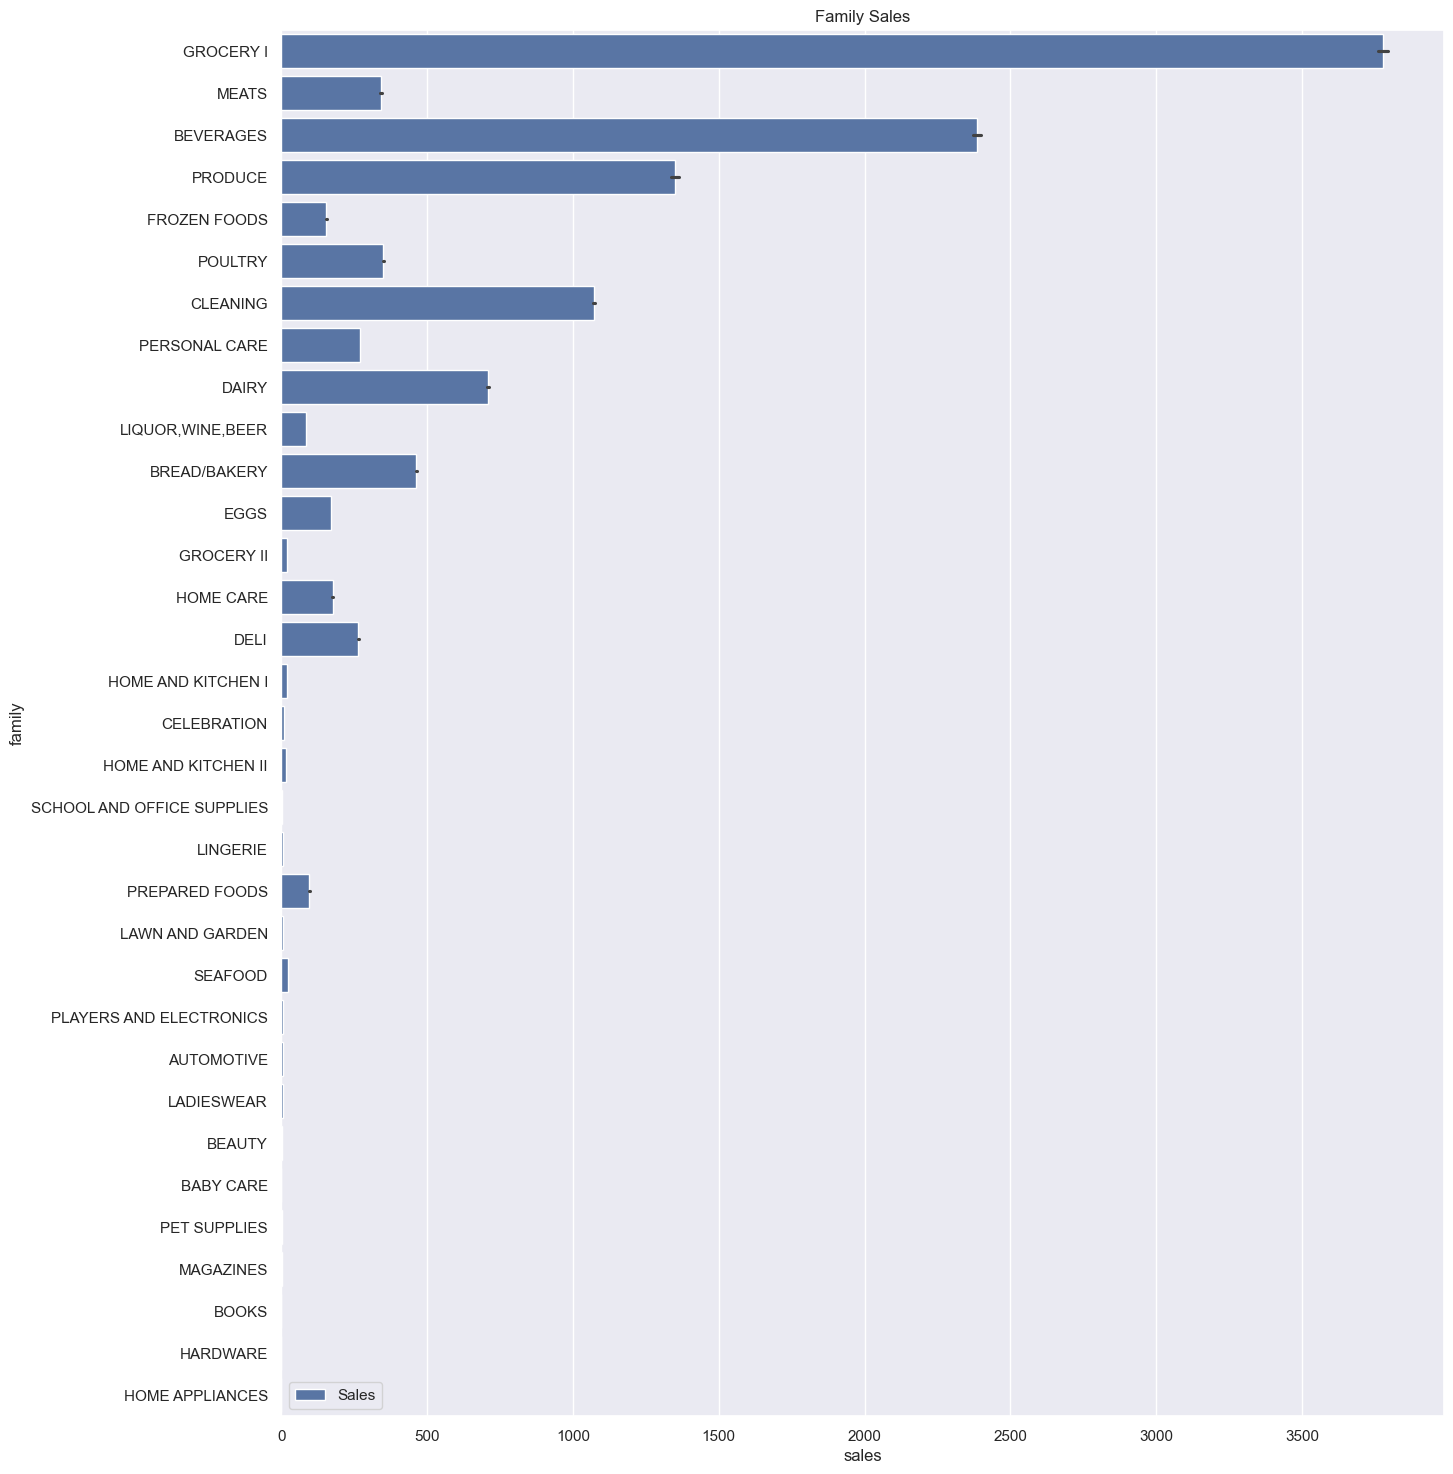

In [25]:
def family_comp(df):
    plt.figure(figsize=(15,18))
    sns.barplot(x="sales", y="family", data=df, label="Sales", color="b")
    plt.legend()
    plt.title('Family Sales')
    plt.show()

family_sort = df_train.sort_values(by=['sales','family'], ascending=False)
family_comp(family_sort)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Distribution of Promotion and Sales:
</span> 

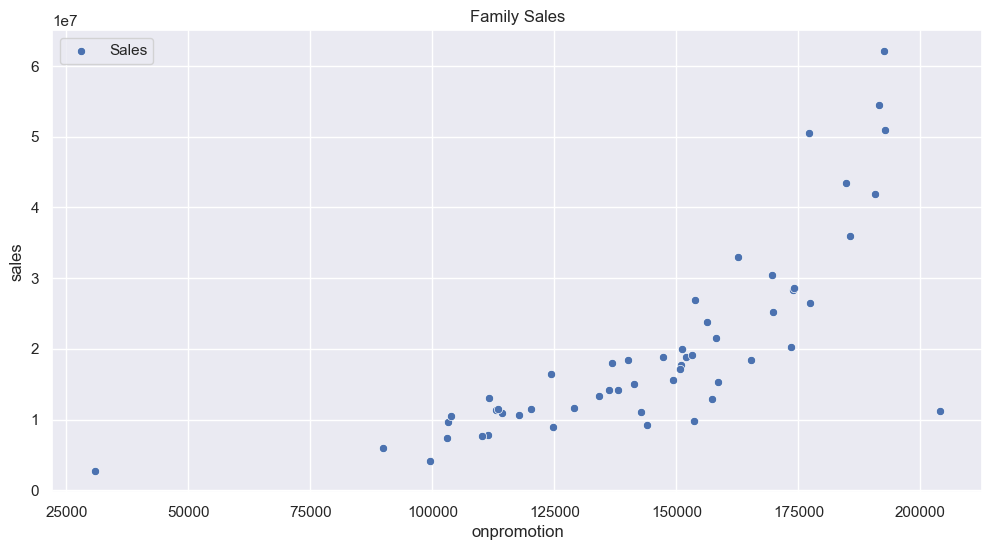

In [26]:
def family_comp(df):
    sns.set(rc={'figure.figsize':fig_size})
    sns.scatterplot(x=df.onpromotion, y=df.sales, label="Sales", color="b")
    plt.legend()
    plt.title('Family Sales')
    plt.show()

promo_sales = df_train.groupby('store_nbr')[['onpromotion','sales']].sum()
family_comp(promo_sales)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Oil Price Distribution:
</span> 

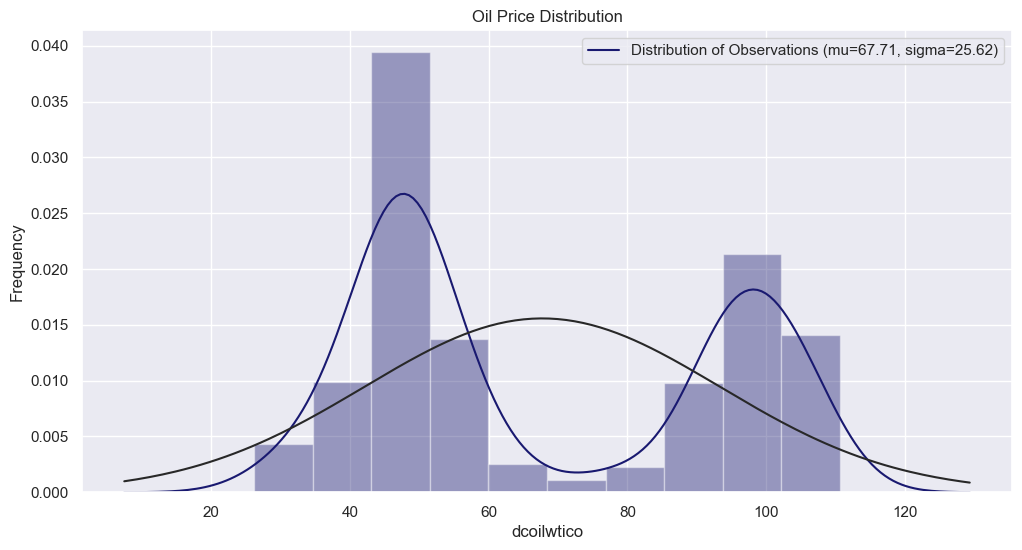

In [27]:
def distplot_feature(target, col):
    sns.set(rc={'figure.figsize':fig_size})        
    sns.distplot(target, fit=norm, color='midnightblue')  
    mu, sigma = norm.fit(target)
    
    plt.legend([f'Distribution of Observations (mu={round(mu,2)}, sigma={round(sigma, 2)})'], loc='upper right')
    plt.ylabel('Frequency')      
    plt.title(f'{col} Distribution', fontsize=12)
    plt.show()

distplot_feature(df_oil.dcoilwtico.dropna(), 'Oil Price')

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Yearly graph of Oil Sales:
</span> 

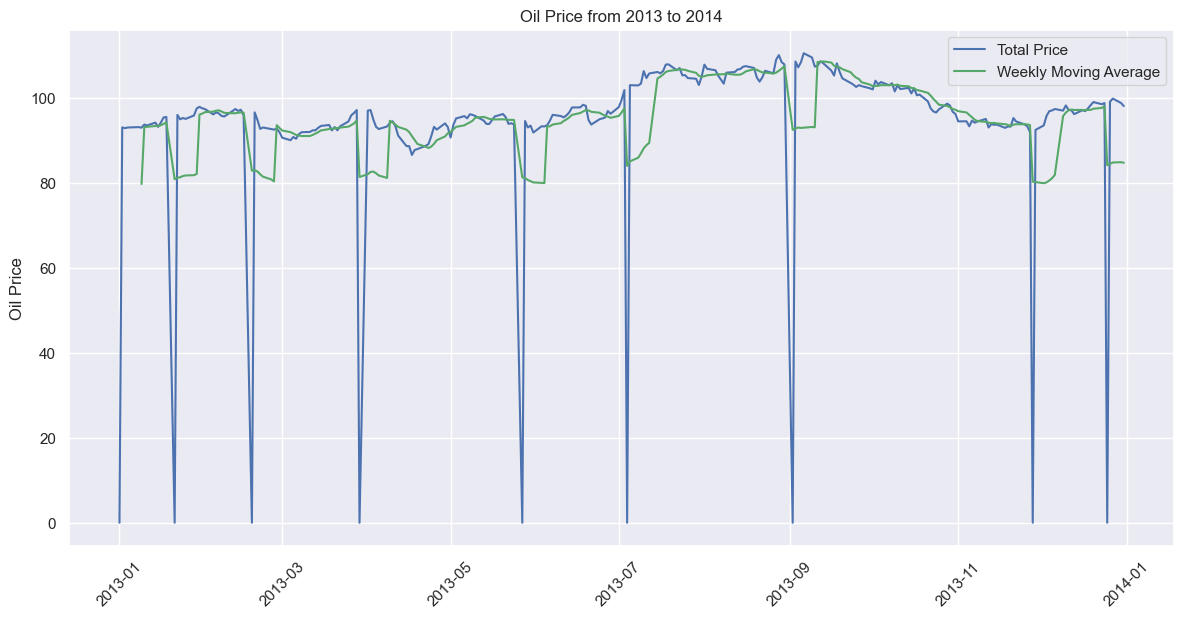

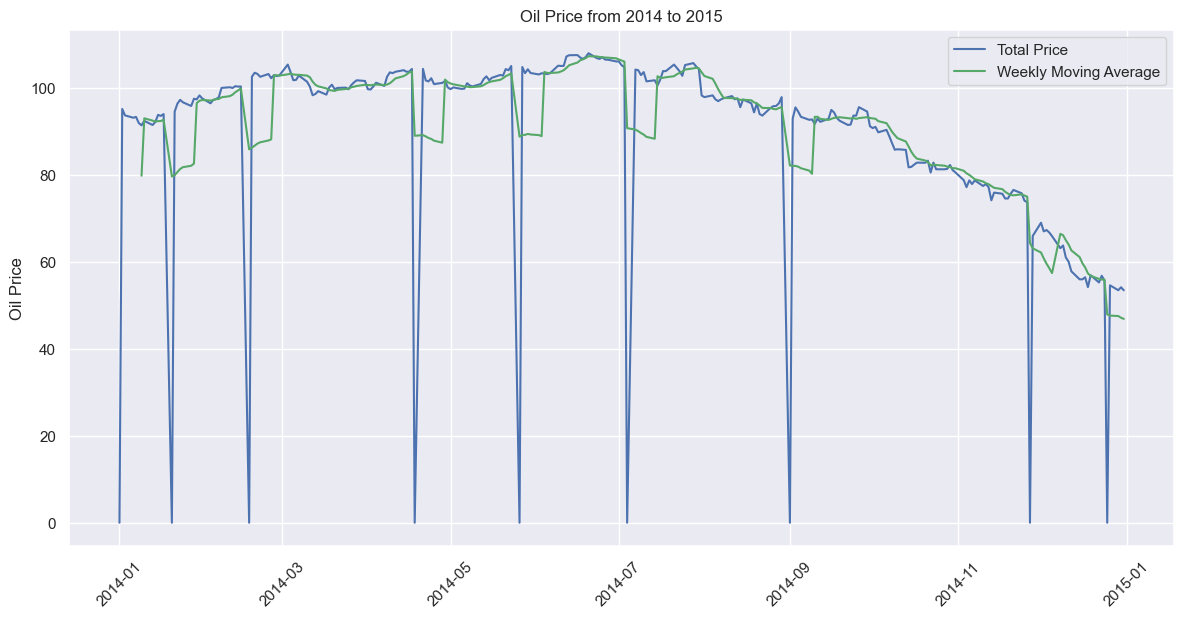

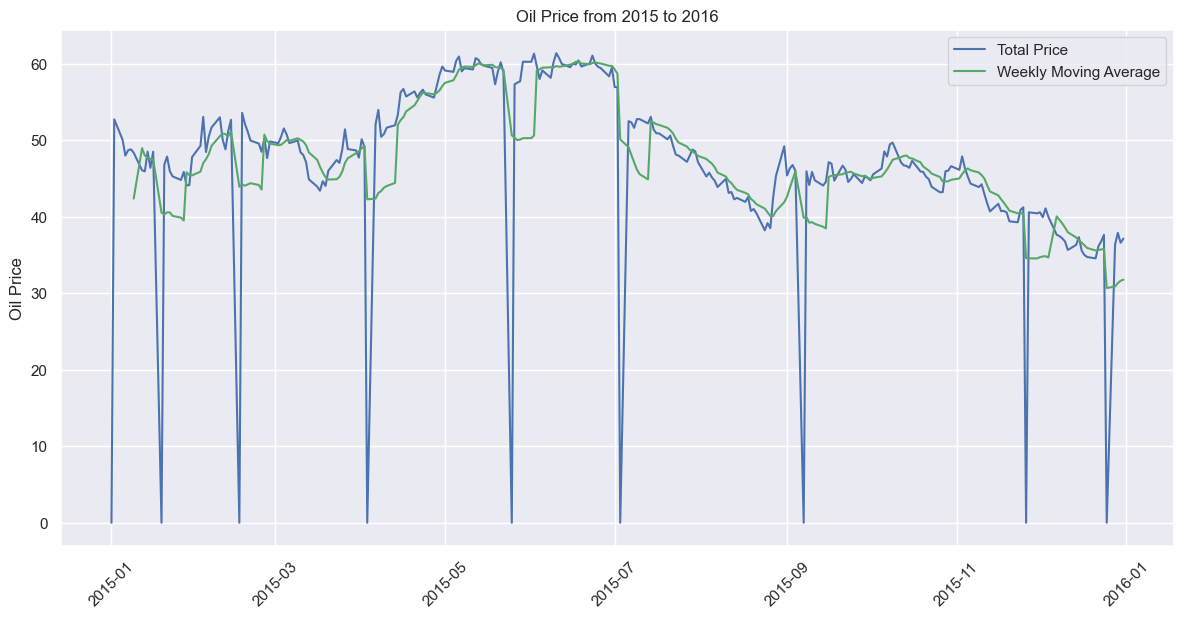

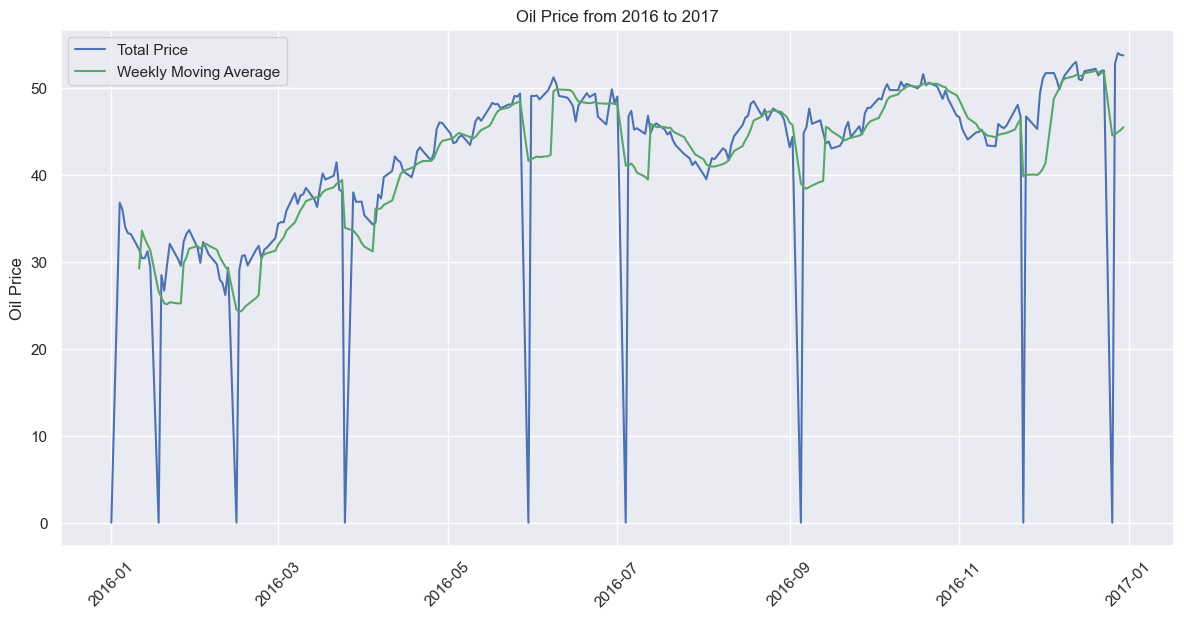

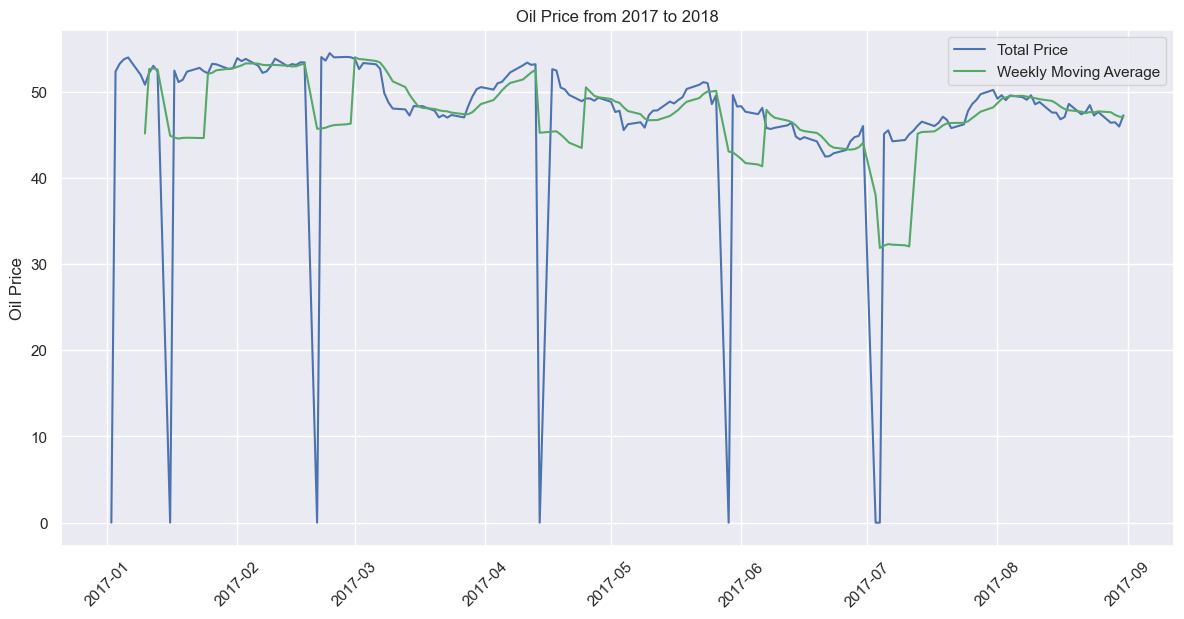

In [28]:
def filter_yearly_graph(df1, df2, year_start, year_end):
    plt.figure(figsize=(fig_size))
    plt.plot(df1.index, df1.values, label='Total Price', color='b')
    plt.plot(df2.index, df2.values, label='Weekly Moving Average', color='g')
    
    plt.title(f'Oil Price from {year_start} to {year_end}')
    plt.ylabel('Oil Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

timeframe = df_oil.year.unique()
daily_oil_sales = df_oil.groupby('date')['dcoilwtico'].sum()

for year in timeframe:
    mask = (daily_oil_sales.index.year >= year) & (daily_oil_sales.index.year < year+1)
    filtered_daily_sales = daily_oil_sales[mask]    
    moving_avg = filtered_daily_sales.rolling(window=7).mean()
    
    filter_yearly_graph(filtered_daily_sales, moving_avg, year, year+1)


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Oil Trends:
</span> 

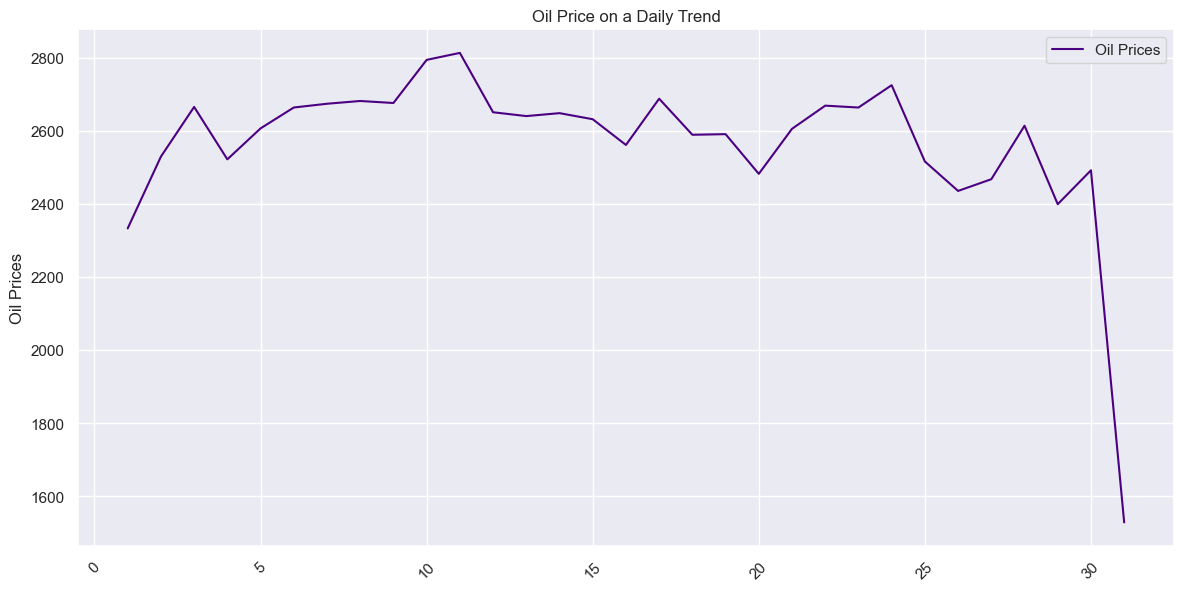

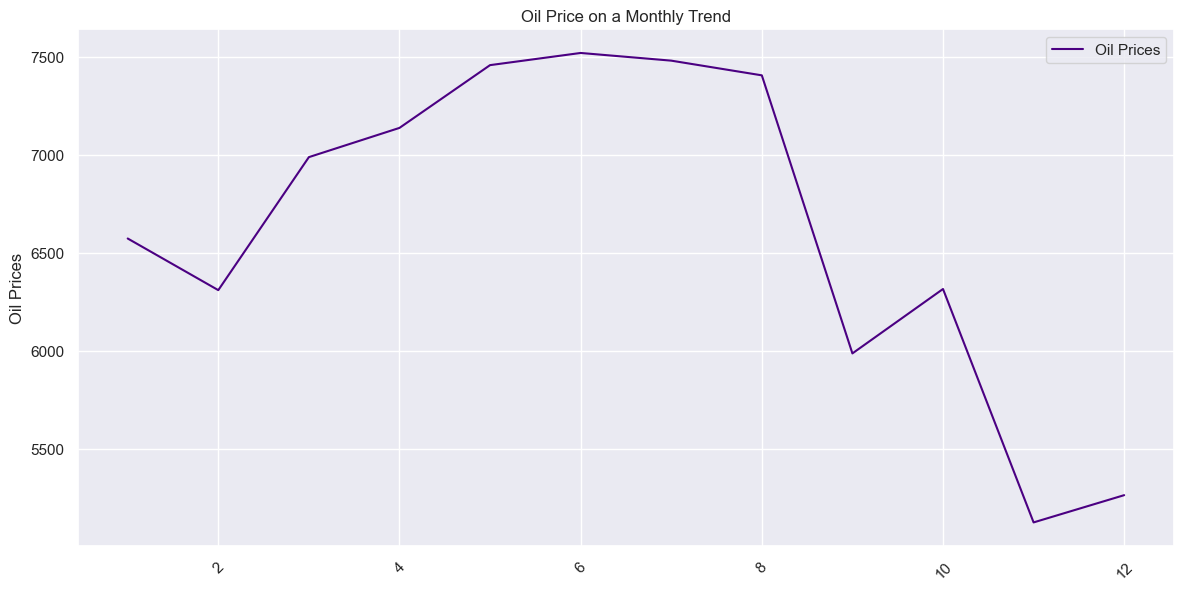

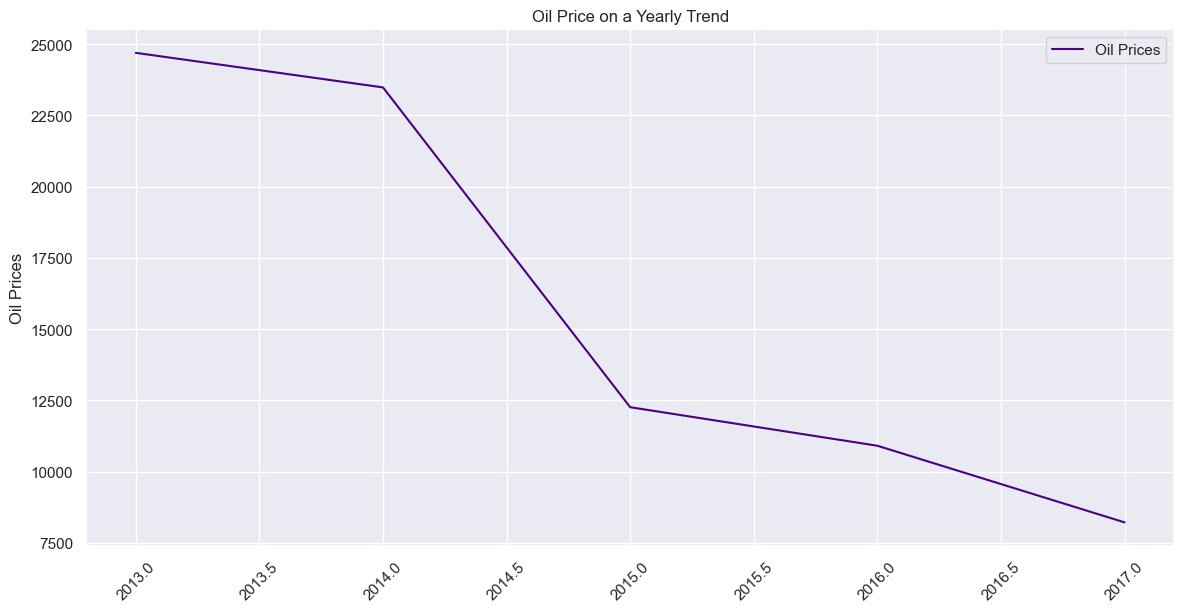

In [29]:
def oil_trend(df, freq):
    plt.figure(figsize=(fig_size))
    plt.plot(df, label='Oil Prices', color='indigo')
    
    plt.title(f'Oil Price on a {freq} Trend')
    plt.ylabel('Oil Prices')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

daily_trend = df_oil.groupby('day')['dcoilwtico'].sum()
monthly_trend = df_oil.groupby('month')['dcoilwtico'].sum()
yearly_trend = df_oil.groupby('year')['dcoilwtico'].sum()

oil_trend(daily_trend, 'Daily')
oil_trend(monthly_trend, 'Monthly')
oil_trend(yearly_trend, 'Yearly')


<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Distribution of Store:
</span> 

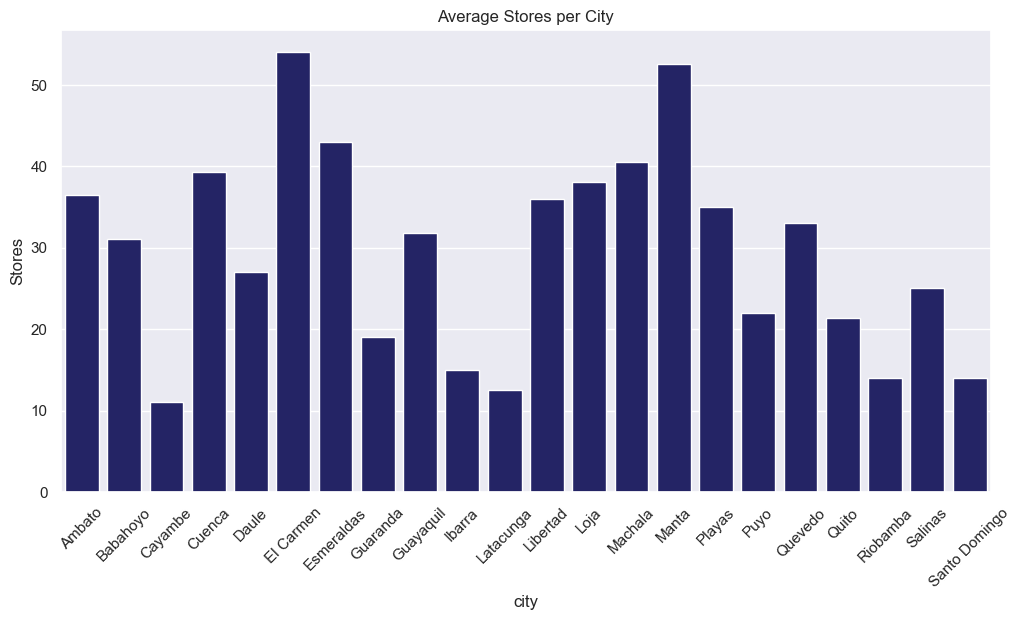

In [30]:
def type_counts(df):
    sns.set(rc={'figure.figsize':fig_size})        
    sns.barplot(df, color='midnightblue')  
    plt.ylabel('Stores')      
    plt.title('Average Stores per City', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

city_stores = df_stores.groupby(['city']).store_nbr.mean()
type_counts(city_stores)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• City Classification by Clusters:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
This lists the number of stores associated with cities that are clustered.
</span> 

In [31]:
city_clusters = pd.DataFrame(df_stores.groupby('cluster').city.unique())
print(f'• Cities present in each Cluster:\n{city_clusters.to_string()}')


• Cities present in each Cluster:
                                                                    city
cluster                                                                 
1                                            [Guayaquil, Salinas, Daule]
2                                                               [Cuenca]
3        [Santo Domingo, Guayaquil, Quevedo, Playas, Machala, El Carmen]
4                                         [Santo Domingo, Loja, Machala]
5                                                                [Quito]
6                     [Quito, Cayambe, Santo Domingo, Guayaquil, Cuenca]
7                                                       [Riobamba, Puyo]
8                                                                [Quito]
9                                                        [Quito, Ambato]
10                           [Guayaquil, Babahoyo, Libertad, Esmeraldas]
11                                                        [Quito, Manta]
12               

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Business Comparison per city:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
The bar plots revealing the average sales and stores in cities.
</span> 

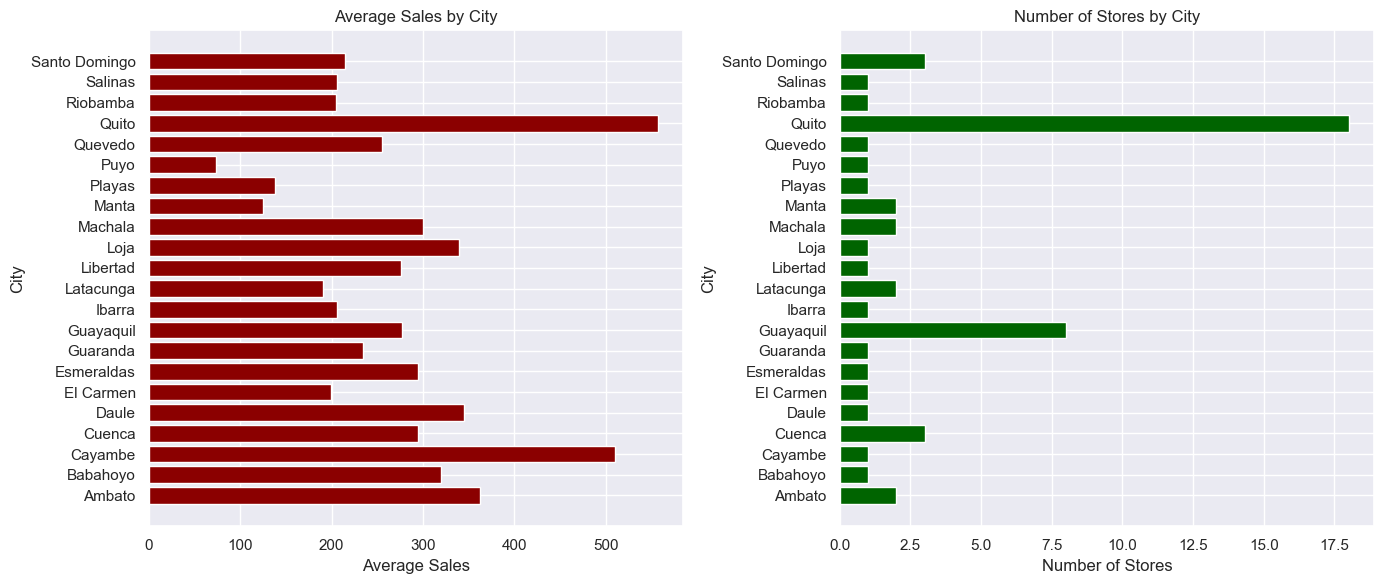

In [32]:
def city_sales_stores(df):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].barh(city_sales.index, city_sales.values, color='darkred')
    ax[0].set_title('Average Sales by City')
    ax[0].set_xlabel('Average Sales')
    ax[0].set_ylabel('City')

    ax[1].barh(city_stores.index, city_stores.values, color='darkgreen')
    ax[1].set_title('Number of Stores by City')
    ax[1].set_xlabel('Number of Stores')
    ax[1].set_ylabel('City')

    plt.tight_layout()
    plt.show()  

city_sales = df_train_store.groupby('city').sales.mean()
city_stores = df_train_store.groupby('city').store_nbr.nunique()
city_sales_stores(city_sales)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Sales per Clusters:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
Mean Sales stores in each Cluster accumulated.
</span> 

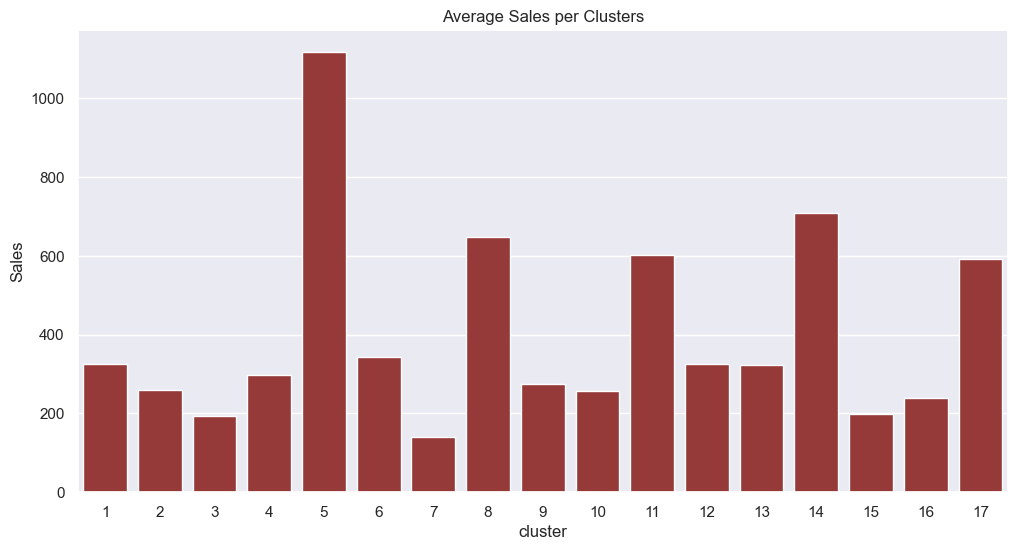

In [33]:
def cluster_sales(df):
    sns.set(rc={'figure.figsize':fig_size})        
    sns.barplot(df, color='brown')  
    plt.ylabel('Sales')      
    plt.title('Average Sales per Clusters', fontsize=12)
    plt.show()

sales_per_cluster = df_train_store.groupby('cluster').sales.mean()
cluster_sales(sales_per_cluster)

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Grouped View:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- Displaying details based on unique clustered city:
</span> 

In [34]:
df_train_store.groupby(['cluster', 'city', 'family']).nunique()

id  store_nbr  sales  \
cluster city          family                                               
1       Daule         AUTOMOTIVE                  1684          1     23   
                      BABY CARE                   1684          1      4   
                      BEAUTY                      1684          1     19   
                      BEVERAGES                   1684          1   1343   
                      BOOKS                       1684          1      4   
                      BREAD/BAKERY                1684          1   1677   
                      CELEBRATION                 1684          1     50   
                      CLEANING                    1684          1    787   
                      DAIRY                       1684          1    899   
                      DELI                        1684          1   1678   
                      EGGS                        1684          1    287   
                      FROZEN FOODS                1684          1   1319   
                      GROCERY I                   1684          1   1321   
                      GROCERY II                  1684          1     69   
                      HARDWARE                    1684          1     15   
                      HOME AND KITCHEN I          1684          1     71   
                      HOME AND KITCHEN II         1684          1     80   
                      HOME APPLIANCES             1684          1      5   
                      HOME CARE                   1684          1    273   
                      LADIESWEAR                  1684          1     36   
                      LAWN AND GARDEN             1684          1     79   
                      LINGERIE                    1684          1     29   
                      LIQUOR,WINE,BEER            1684          1    467   
                      MAGAZINES                   1684          1     18   
                      MEATS                       1684          1   1677   
                      PERSONAL CARE               1684          1    347   
                      PET SUPPLIES                1684          1     28   
                      PLAYERS AND ELECTRONICS     1684          1     35   
                      POULTRY                     1684          1   1675   
                      PREPARED FOODS              1684          1   1613   
                      PRODUCE                     1684          1   1063   
                      SCHOOL AND OFFICE SUPPLIES  1684          1     21   
                      SEAFOOD                     1684          1   1625   
        Guayaquil     AUTOMOTIVE                  1684          1     23   
                      BABY CARE                   1684          1      4   
                      BEAUTY                      1684          1     19   
                      BEVERAGES                   1684          1   1296   
                      BOOKS                       1684          1      8   
                      BREAD/BAKERY                1684          1   1576   
                      CELEBRATION                 1684          1     51   
                      CLEANING                    1684          1    659   
                      DAIRY                       1684          1    851   
                      DELI                        1684          1   1573   
                      EGGS                        1684          1    196   
                      FROZEN FOODS                1684          1   1521   
                      GROCERY I                   1684          1   1160   
                      GROCERY II                  1684          1     80   
                      HARDWARE                    1684          1     12   
                      HOME AND KITCHEN I          1684          1     78   
                      HOME AND KITCHEN II         1684          1    154   
                      HOME APPLIANCES             1684          1      7   
                      HO

### Shahriar --->

In [35]:
# something, something

### Camilla --->

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Joint Plottings:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- The joint plot is a way of understanding the relationship between two variables and the distribution of individuals in each variable, especially how the main contributing variables influence the target variable.
</span> 

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- From the sales vs onpromotion plot, very clear distinction relationship can be observed resembling a straight line graph.
</span> <br> 
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- From the sales vs dcoilwtico plot, most of the data point is ambiguous. However, there are portions in the samples, where the lower price of the oil allows more sales in stores. 
</span> <br> 
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- From the transactions vs sales plot, a more clear straight line can be observed, proving that the increase in transactions allows an increase in sales (in units).  
</span> 

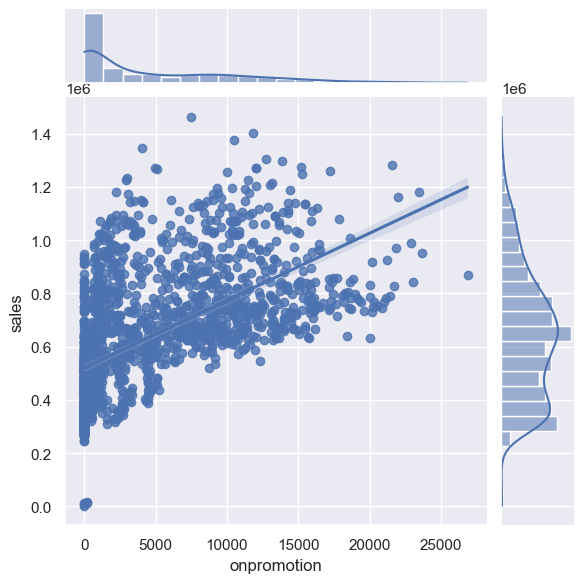

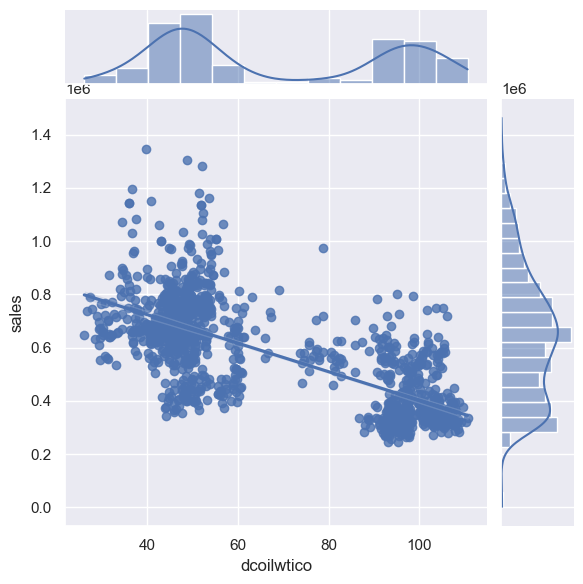

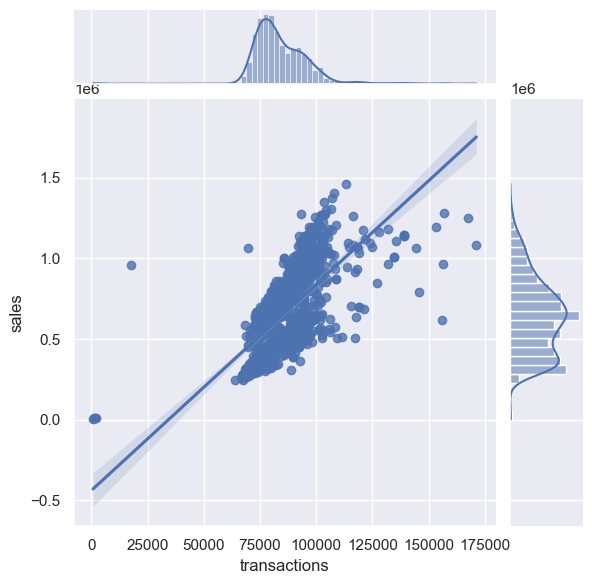

In [36]:
def joint_compare(feature, target):
    sns.set(rc={'figure.figsize':fig_size})
    sns.jointplot(x=feature, y=target, kind='reg', height=6)
    plt.show()

df_merge = df_merge.reset_index(drop=True)
target_feature = df_merge.sales
compare_features = ['onpromotion', 'dcoilwtico', 'transactions']

for feature in compare_features:
    joint_compare(df_merge[feature], target_feature)
    

<span style="font-family:Cambria; color:#0261ab; font-size: 22px; text-shadow: 0.5px 0.5px black"> 
• Pearson Correlation Matrix:
</span> <br>
<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- In statistics, the Pearson Correlation Coefficient is a correlation coefficient that measures the linear correlation between two sets of data.
</span> 

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- First step is to deal with NaN values that appears in the oil price.
</span> 

In [37]:
df_merge.dcoilwtico.fillna(value=df_merge.dcoilwtico.mean() , inplace=True) 
df_merge.head()

sales  onpromotion  transactions      type    locale locale_name  \
0    2511.618999            0         770.0   Holiday  National     Ecuador   
1  496092.417944            0       93215.0       NaN       NaN         NaN   
2  361461.231124            0       78504.0       NaN       NaN         NaN   
3  354459.677093            0       78494.0       NaN       NaN         NaN   
4  477350.121229            0       93573.0  Work Day  National     Ecuador   

               description transferred  dcoilwtico  day  month  year  
0       Primer dia del ano       False   68.015874    1      1  2013  
1                      NaN         NaN   93.140000    2      1  2013  
2                      NaN         NaN   92.970000    3      1  2013  
3                      NaN         NaN   93.120000    4      1  2013  
4  Recupero puente Navidad       False   68.015874    5      1  2013

<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- Next to generate the matrix in statistical terms.
</span> 

In [38]:
def pearson_matrix(df):
    print(df.corr(numeric_only=True))

print('Printing the Pearson Matrix:')
pearson_matrix(df_merge)

Printing the Pearson Matrix:
                 sales  onpromotion  transactions  dcoilwtico       day  \
sales         1.000000     0.578671      0.679054   -0.483650 -0.100056   
onpromotion   0.578671     1.000000      0.206505   -0.552621  0.004460   
transactions  0.679054     0.206505      1.000000   -0.213762 -0.042463   
dcoilwtico   -0.483650    -0.552621     -0.213762    1.000000  0.000225   
day          -0.100056     0.004460     -0.042463    0.000225  1.000000   
month         0.169241     0.103177      0.212249    0.003413  0.005777   
year          0.679639     0.801676      0.214201   -0.688361 -0.014563   

                 month      year  
sales         0.169241  0.679639  
onpromotion   0.103177  0.801676  
transactions  0.212249  0.214201  
dcoilwtico    0.003413 -0.688361  
day           0.005777 -0.014563  
month         1.000000 -0.143380  
year         -0.143380  1.000000  


<span style="font-family:Cambria; color:#0261ab; font-size: 17px; text-shadow: 0.5px 0.5px black"> 
- A visual representation of the Pearson Correlation Matrix by applying a Heatmap on the merged dataframe.
</span> 

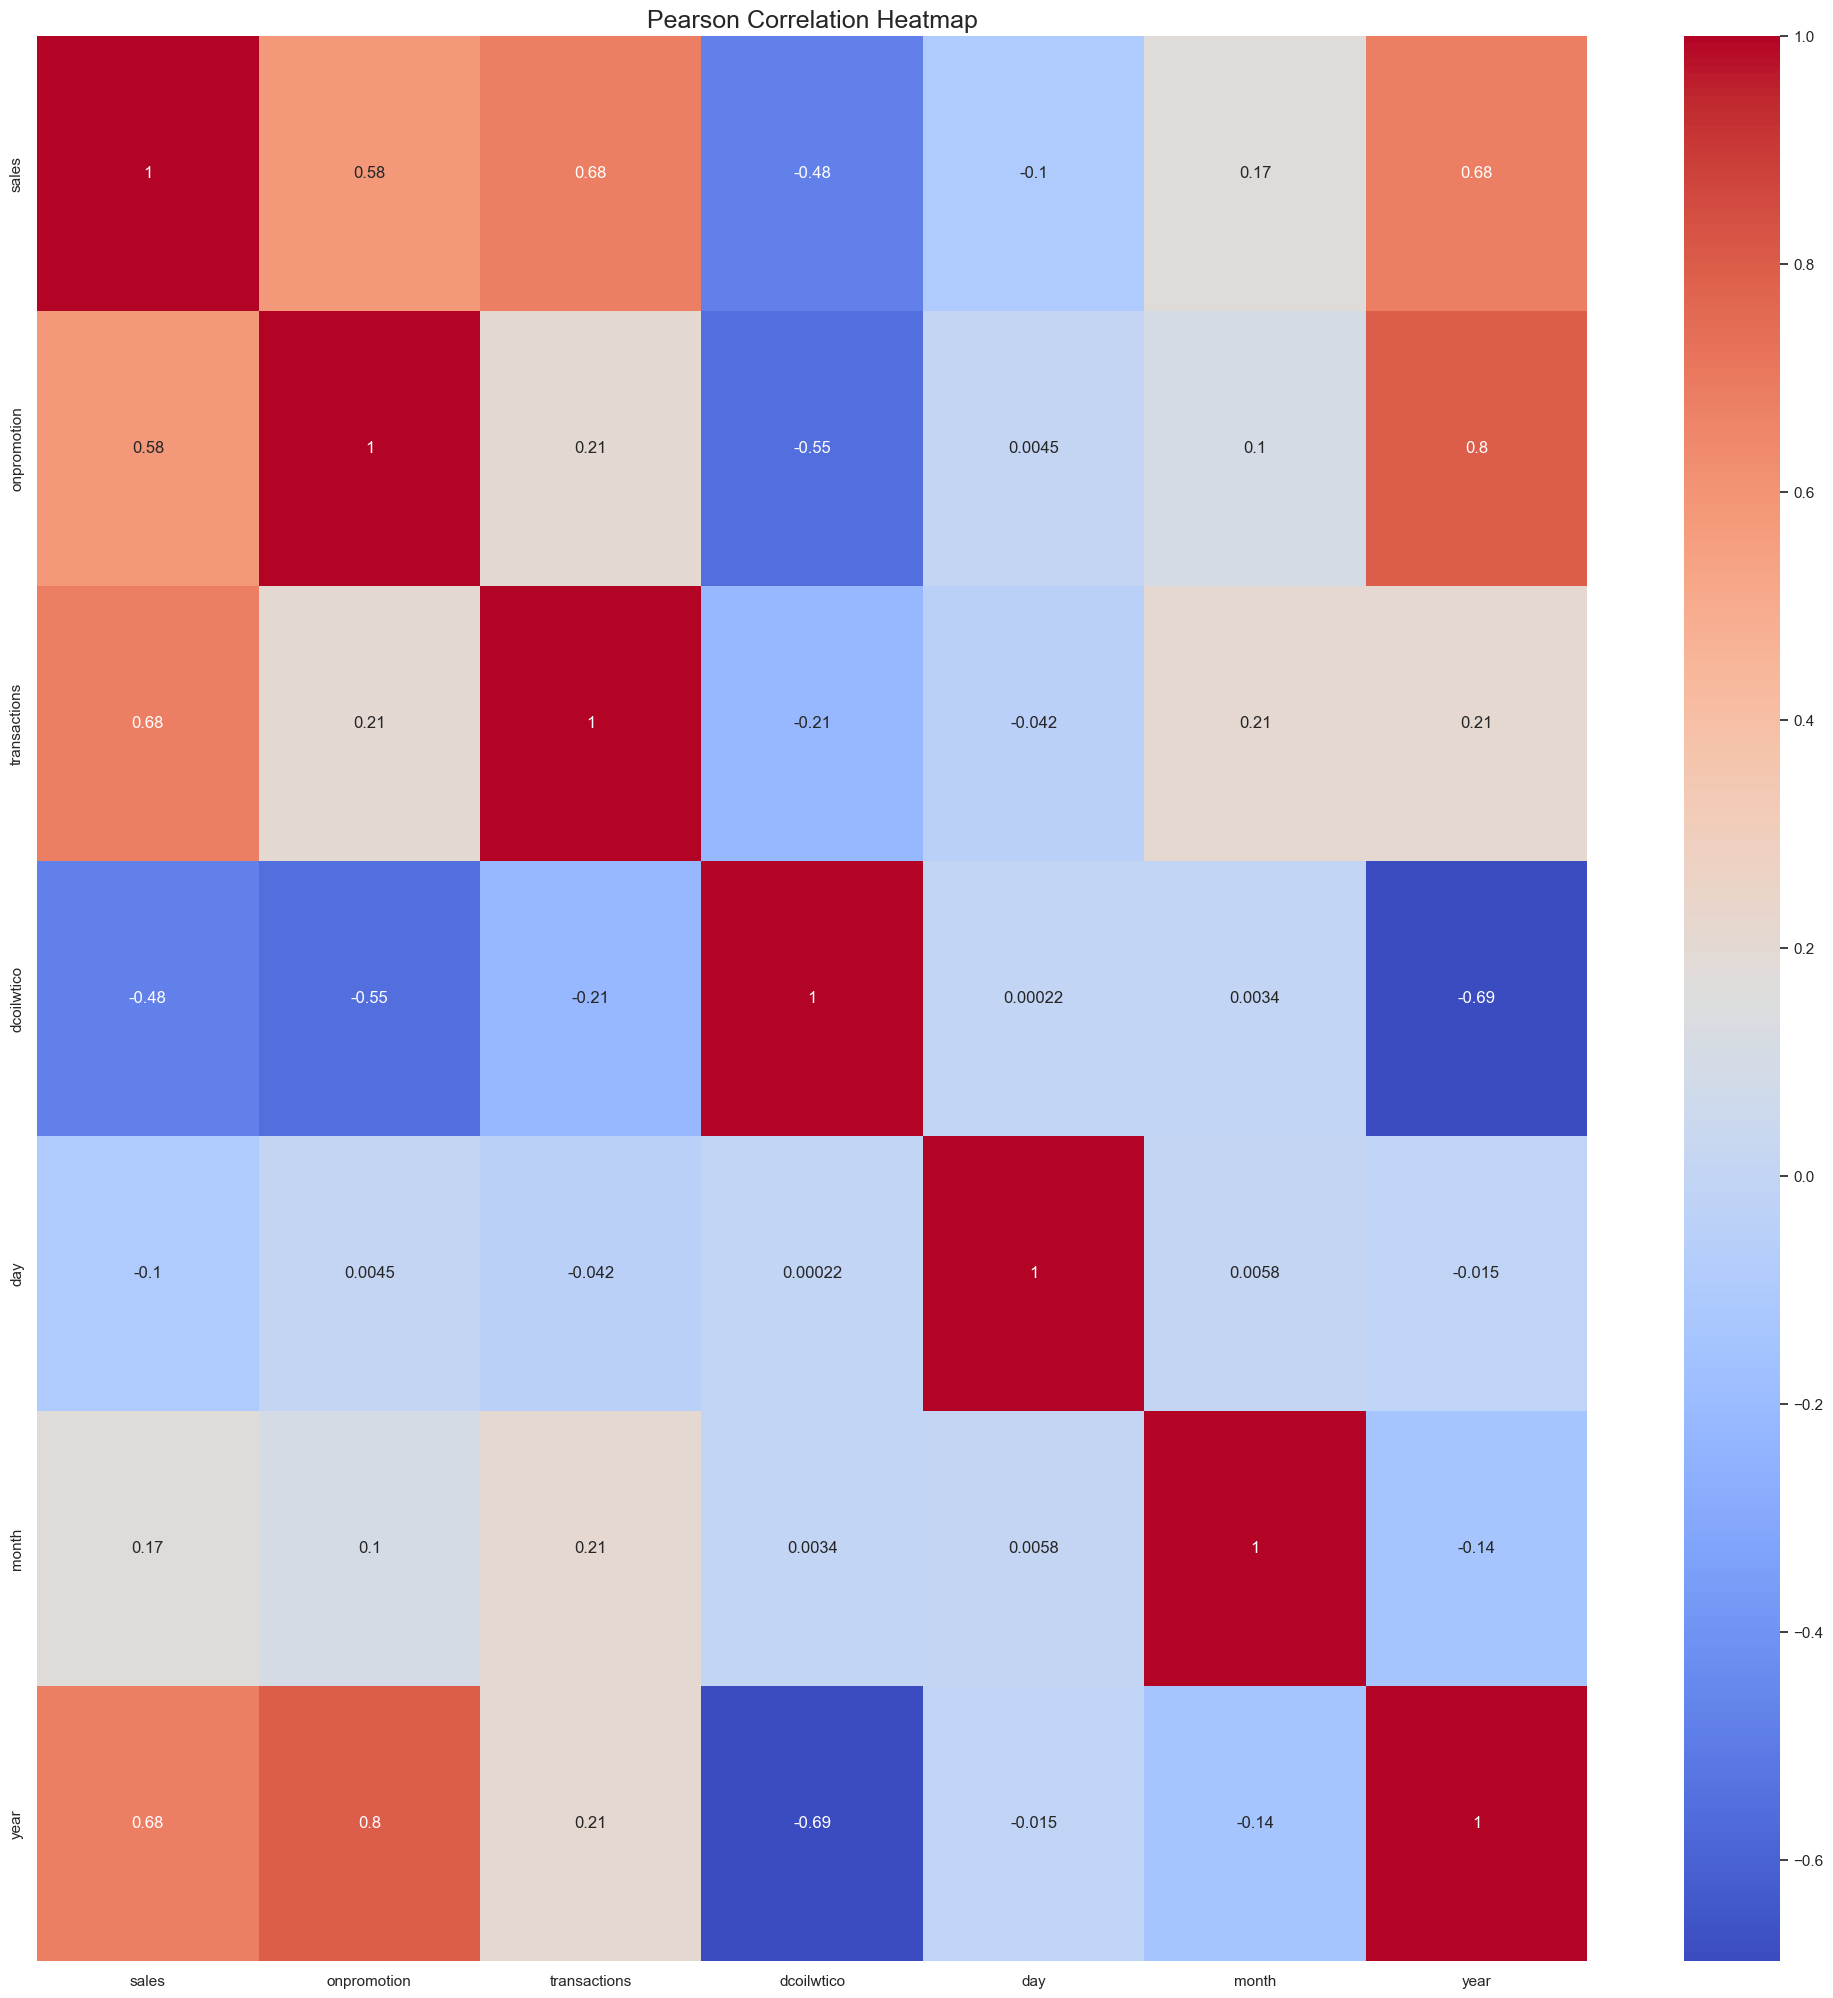

In [39]:
def pearson_correlation(df):
    plt.figure(figsize=(25, 25))
    color = plt.get_cmap('coolwarm')
    data = sns.heatmap(df.corr(numeric_only=True), cmap=color, annot=True, fmt='.2g')
    plt.title("Pearson Correlation Heatmap", fontsize=18)
    plt.show()

pearson_correlation(df_merge)

In [40]:
### to be continued after our next discussion xD 